In [1]:
import numpy as np
import pandas as pd
import locale
import json
import re
import pymorphy2
import torch
import accelerate
import matplotlib.pyplot as plt
from datetime import datetime
from transformers import T5ForConditionalGeneration, Trainer, TrainingArguments, T5Config, T5Tokenizer, TrainerCallback, Seq2SeqTrainingArguments, Seq2SeqTrainer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from bs4 import BeautifulSoup
from sklearn.model_selection import train_test_split
from datasets import Dataset
from peft import get_peft_model, LoraConfig

/Users/alexanderknyshov/Desktop/LLM/Data/venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Loading JSON-dataset to dictionary
with open('/Users/alexanderknyshov/Desktop/LLM/Data/datasets/train_set.json', 'r') as json_file:
    data = json.load(json_file)

In [3]:
def format_text(text):
    news_text = "form a recommendation using news: " + " ".join(text['news'])
    recommendation_text = " ".join(text['recommendations'])
    return {'input_text': news_text, 'target_text': recommendation_text}

# Formatting original dataset
dataset = Dataset.from_dict(data)
dataset = dataset.map(format_text)
# Removing unneccessery columns
dataset = dataset.remove_columns(['news', 'recommendations'])

Map: 100%|██████████| 5177/5177 [00:02<00:00, 1986.76 examples/s]


In [4]:
# Splitting into train and validate data
split_ratio = 0.8
split_index = int(len(data['news']) * split_ratio)

train_news = data['news'][:split_index]
train_recommendations = data['recommendations'][:split_index]
train_data = {'news': train_news, 'recommendations': train_recommendations}

val_news = data['news'][split_index:]
val_recommendations = data['recommendations'][split_index:]
val_data = {'news': val_news, 'recommendations': val_recommendations}

# Returning to the format needed
train_dataset = Dataset.from_dict(train_data)
train_dataset = train_dataset.map(format_text)
train_dataset = train_dataset.remove_columns(['news', 'recommendations'])

val_dataset = Dataset.from_dict(val_data)
val_dataset = val_dataset.map(format_text)
val_dataset = val_dataset.remove_columns(['news', 'recommendations'])

Map: 100%|██████████| 1036/1036 [00:00<00:00, 2918.17 examples/s]


In [5]:
class LossLogger(TrainerCallback):
    def __init__(self):
        self.train_losses = []
        self.eval_losses = []

    def on_log(self, args, state, control, logs=None, **kwargs):
        if logs is not None:
            if "loss" in logs:
                self.train_losses.append(logs["loss"])
            if "eval_loss" in logs:
                self.eval_losses.append(logs["eval_loss"])

loss_logger = LossLogger()

In [6]:
# Loading the tokenizer
tokenizer = T5Tokenizer.from_pretrained('cointegrated/rut5-small')

# Method for data tokenization
def tokenize_data(example):
    input_encodings = tokenizer(example['input_text'], padding='max_length', truncation=True, max_length=1024)
    target_encodings = tokenizer(example['target_text'], padding='max_length', truncation=True, max_length=512)

    example['input_ids'] = input_encodings['input_ids']
    example['attention_mask'] = input_encodings['attention_mask']
    example['labels'] = target_encodings['input_ids']
    return example

# Train and validation data tokenization
tokenized_train_dataset = train_dataset.map(tokenize_data)
tokenized_val_dataset = val_dataset.map(tokenize_data)

# Getting rid of text columns
tokenized_train_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])
tokenized_val_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
/Users/alexanderknyshov/Desktop/LLM/Data/venv/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Map: 100%|██████████| 1036/1036 [00:02<00:00, 447.79 examples/s]


In [7]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

In [8]:
lora_config = LoraConfig(
    r=16,                       # Ранг, может быть изменен в зависимости от задачи
    lora_alpha=32,             # Гиперпараметр, который можно настроить
    lora_dropout=0.1,          # Вероятность дропаута для LoRA
    target_modules=["q", "v"]  # Модули, которые будут адаптированы
)
config = T5Config.from_pretrained('cointegrated/rut5-small', dropout_rate=0.1)

You are using a model of type mt5 to instantiate a model of type t5. This is not supported for all configurations of models and can yield errors.


In [9]:
# Model Loading
model = T5ForConditionalGeneration.from_pretrained('cointegrated/rut5-small', config=config).to(device)
model = get_peft_model(model, lora_config)

# Defining training params
training_args = Seq2SeqTrainingArguments(
    output_dir= '/Users/alexanderknyshov/Desktop/LLM/Data/model',
    per_device_train_batch_size=1,
    per_device_eval_batch_size=1,
    num_train_epochs=1,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    logging_steps=10
)

# Metrics count
# def compute_metrics(eval_pred):
#     predictions, labels = eval_pred
#     decoded_preds = tokenizer.batch_decode(predictions, skip_special_tokens=True)
#     decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)
#     loss = sum([1 if pred == label else 0 for pred, label in zip(decoded_preds, decoded_labels)]) / len(decoded_preds)
#     return {'accuracy': loss}

# Trainer
trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train_dataset,
    eval_dataset=tokenized_val_dataset,
    tokenizer=tokenizer,
    callbacks=[loss_logger]
)

/Users/alexanderknyshov/Desktop/LLM/Data/venv/lib/python3.11/site-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [10]:
trainer.train()
torch.mps.empty_cache()

  0%|          | 10/4141 [00:03<18:45,  3.67it/s]

{'loss': 10.128, 'grad_norm': 1.6438144445419312, 'learning_rate': 4.987925621830476e-05, 'epoch': 0.0}


  0%|          | 20/4141 [00:05<18:18,  3.75it/s]

{'loss': 9.5442, 'grad_norm': 1.4219435453414917, 'learning_rate': 4.975851243660952e-05, 'epoch': 0.0}


  1%|          | 30/4141 [00:08<18:18,  3.74it/s]

{'loss': 8.7077, 'grad_norm': 1.403282642364502, 'learning_rate': 4.9637768654914274e-05, 'epoch': 0.01}


  1%|          | 40/4141 [00:11<18:15,  3.75it/s]

{'loss': 8.1272, 'grad_norm': 1.1129870414733887, 'learning_rate': 4.951702487321903e-05, 'epoch': 0.01}


  1%|          | 50/4141 [00:13<18:10,  3.75it/s]

{'loss': 6.6788, 'grad_norm': 1.0974041223526, 'learning_rate': 4.939628109152379e-05, 'epoch': 0.01}


  1%|▏         | 60/4141 [00:16<18:09,  3.74it/s]

{'loss': 9.3498, 'grad_norm': 0.9270386099815369, 'learning_rate': 4.9275537309828546e-05, 'epoch': 0.01}


  2%|▏         | 70/4141 [00:19<18:07,  3.74it/s]

{'loss': 9.1705, 'grad_norm': 1.2982908487319946, 'learning_rate': 4.91547935281333e-05, 'epoch': 0.02}


  2%|▏         | 80/4141 [00:21<18:08,  3.73it/s]

{'loss': 7.8734, 'grad_norm': 0.9047701954841614, 'learning_rate': 4.903404974643806e-05, 'epoch': 0.02}


  2%|▏         | 90/4141 [00:24<18:06,  3.73it/s]

{'loss': 8.1809, 'grad_norm': 3.533386707305908, 'learning_rate': 4.891330596474282e-05, 'epoch': 0.02}


  2%|▏         | 100/4141 [00:27<17:58,  3.75it/s]

{'loss': 8.445, 'grad_norm': 0.7952601313591003, 'learning_rate': 4.8792562183047574e-05, 'epoch': 0.02}


  3%|▎         | 110/4141 [00:29<17:56,  3.74it/s]

{'loss': 6.9276, 'grad_norm': 0.8743174076080322, 'learning_rate': 4.867181840135233e-05, 'epoch': 0.03}


  3%|▎         | 120/4141 [00:32<17:51,  3.75it/s]

{'loss': 6.8436, 'grad_norm': 2.016037940979004, 'learning_rate': 4.855107461965709e-05, 'epoch': 0.03}


  3%|▎         | 130/4141 [00:35<17:55,  3.73it/s]

{'loss': 6.4937, 'grad_norm': 0.8112303614616394, 'learning_rate': 4.8430330837961846e-05, 'epoch': 0.03}


  3%|▎         | 140/4141 [00:37<17:48,  3.74it/s]

{'loss': 8.4079, 'grad_norm': 3.90670108795166, 'learning_rate': 4.83095870562666e-05, 'epoch': 0.03}


  4%|▎         | 150/4141 [00:40<17:47,  3.74it/s]

{'loss': 6.731, 'grad_norm': 0.7613009214401245, 'learning_rate': 4.818884327457136e-05, 'epoch': 0.04}


  4%|▍         | 160/4141 [00:43<17:47,  3.73it/s]

{'loss': 6.6341, 'grad_norm': 0.6247504949569702, 'learning_rate': 4.806809949287612e-05, 'epoch': 0.04}


  4%|▍         | 170/4141 [00:45<17:42,  3.74it/s]

{'loss': 8.5614, 'grad_norm': 0.6765254139900208, 'learning_rate': 4.7947355711180875e-05, 'epoch': 0.04}


  4%|▍         | 180/4141 [00:48<17:43,  3.72it/s]

{'loss': 6.7763, 'grad_norm': 5.102245330810547, 'learning_rate': 4.782661192948563e-05, 'epoch': 0.04}


  5%|▍         | 190/4141 [00:51<17:36,  3.74it/s]

{'loss': 7.7917, 'grad_norm': 0.6837461590766907, 'learning_rate': 4.770586814779039e-05, 'epoch': 0.05}


  5%|▍         | 200/4141 [00:54<17:33,  3.74it/s]

{'loss': 6.3444, 'grad_norm': 0.8128042221069336, 'learning_rate': 4.7585124366095146e-05, 'epoch': 0.05}


  5%|▌         | 210/4141 [00:56<17:32,  3.74it/s]

{'loss': 8.8024, 'grad_norm': 0.6752580404281616, 'learning_rate': 4.7464380584399904e-05, 'epoch': 0.05}


  5%|▌         | 220/4141 [00:59<17:39,  3.70it/s]

{'loss': 7.8793, 'grad_norm': 2.8162479400634766, 'learning_rate': 4.734363680270466e-05, 'epoch': 0.05}


  6%|▌         | 230/4141 [01:02<17:30,  3.72it/s]

{'loss': 7.2925, 'grad_norm': 0.7089207768440247, 'learning_rate': 4.722289302100942e-05, 'epoch': 0.06}


  6%|▌         | 240/4141 [01:04<17:24,  3.73it/s]

{'loss': 8.5181, 'grad_norm': 0.772678792476654, 'learning_rate': 4.7102149239314175e-05, 'epoch': 0.06}


  6%|▌         | 250/4141 [01:07<17:22,  3.73it/s]

{'loss': 7.5647, 'grad_norm': 0.7406882047653198, 'learning_rate': 4.698140545761893e-05, 'epoch': 0.06}


  6%|▋         | 260/4141 [01:10<17:23,  3.72it/s]

{'loss': 7.1261, 'grad_norm': 22.59151840209961, 'learning_rate': 4.6860661675923696e-05, 'epoch': 0.06}


  7%|▋         | 270/4141 [01:12<17:31,  3.68it/s]

{'loss': 7.1809, 'grad_norm': 1.7375564575195312, 'learning_rate': 4.6739917894228454e-05, 'epoch': 0.07}


  7%|▋         | 280/4141 [01:15<17:24,  3.70it/s]

{'loss': 6.6838, 'grad_norm': 0.7603324055671692, 'learning_rate': 4.661917411253321e-05, 'epoch': 0.07}


  7%|▋         | 290/4141 [01:18<17:15,  3.72it/s]

{'loss': 7.8512, 'grad_norm': 2.6726372241973877, 'learning_rate': 4.649843033083797e-05, 'epoch': 0.07}


  7%|▋         | 300/4141 [01:21<17:12,  3.72it/s]

{'loss': 6.5039, 'grad_norm': 1.029684066772461, 'learning_rate': 4.6377686549142725e-05, 'epoch': 0.07}


  7%|▋         | 310/4141 [01:23<17:19,  3.69it/s]

{'loss': 7.8987, 'grad_norm': 0.8026126027107239, 'learning_rate': 4.625694276744748e-05, 'epoch': 0.07}


  8%|▊         | 320/4141 [01:26<17:03,  3.73it/s]

{'loss': 6.3268, 'grad_norm': 0.7385218739509583, 'learning_rate': 4.613619898575224e-05, 'epoch': 0.08}


  8%|▊         | 330/4141 [01:29<17:03,  3.72it/s]

{'loss': 6.5479, 'grad_norm': 0.8945876359939575, 'learning_rate': 4.6015455204057e-05, 'epoch': 0.08}


  8%|▊         | 340/4141 [01:31<16:58,  3.73it/s]

{'loss': 7.3554, 'grad_norm': 13.656648635864258, 'learning_rate': 4.5894711422361754e-05, 'epoch': 0.08}


  8%|▊         | 350/4141 [01:34<16:55,  3.73it/s]

{'loss': 6.0982, 'grad_norm': 1.0365774631500244, 'learning_rate': 4.577396764066651e-05, 'epoch': 0.08}


  9%|▊         | 360/4141 [01:37<17:13,  3.66it/s]

{'loss': 7.5847, 'grad_norm': 0.720583975315094, 'learning_rate': 4.565322385897127e-05, 'epoch': 0.09}


  9%|▉         | 370/4141 [01:39<17:21,  3.62it/s]

{'loss': 6.5273, 'grad_norm': 1.102684497833252, 'learning_rate': 4.5532480077276025e-05, 'epoch': 0.09}


  9%|▉         | 380/4141 [01:42<16:42,  3.75it/s]

{'loss': 6.7633, 'grad_norm': 0.9095370173454285, 'learning_rate': 4.541173629558078e-05, 'epoch': 0.09}


  9%|▉         | 390/4141 [01:45<16:42,  3.74it/s]

{'loss': 6.3679, 'grad_norm': 1.2453242540359497, 'learning_rate': 4.529099251388554e-05, 'epoch': 0.09}


 10%|▉         | 400/4141 [01:47<16:39,  3.74it/s]

{'loss': 6.2772, 'grad_norm': 0.5635246634483337, 'learning_rate': 4.51702487321903e-05, 'epoch': 0.1}


 10%|▉         | 410/4141 [01:50<17:18,  3.59it/s]

{'loss': 6.2508, 'grad_norm': 0.6796528100967407, 'learning_rate': 4.5049504950495054e-05, 'epoch': 0.1}


 10%|█         | 420/4141 [01:53<17:25,  3.56it/s]

{'loss': 5.901, 'grad_norm': 0.6802305579185486, 'learning_rate': 4.492876116879981e-05, 'epoch': 0.1}


 10%|█         | 430/4141 [01:56<17:16,  3.58it/s]

{'loss': 6.8245, 'grad_norm': 2.14050555229187, 'learning_rate': 4.480801738710457e-05, 'epoch': 0.1}


 11%|█         | 440/4141 [01:58<16:24,  3.76it/s]

{'loss': 7.1717, 'grad_norm': 0.6350073218345642, 'learning_rate': 4.4687273605409326e-05, 'epoch': 0.11}


 11%|█         | 450/4141 [02:01<16:18,  3.77it/s]

{'loss': 5.7106, 'grad_norm': 0.6867501139640808, 'learning_rate': 4.456652982371408e-05, 'epoch': 0.11}


 11%|█         | 460/4141 [02:04<16:15,  3.77it/s]

{'loss': 7.2886, 'grad_norm': 2.487680435180664, 'learning_rate': 4.444578604201884e-05, 'epoch': 0.11}


 11%|█▏        | 470/4141 [02:06<16:13,  3.77it/s]

{'loss': 6.9966, 'grad_norm': 21.334884643554688, 'learning_rate': 4.43250422603236e-05, 'epoch': 0.11}


 12%|█▏        | 480/4141 [02:09<16:12,  3.77it/s]

{'loss': 6.5906, 'grad_norm': 0.7104122042655945, 'learning_rate': 4.4204298478628355e-05, 'epoch': 0.12}


 12%|█▏        | 490/4141 [02:12<16:09,  3.77it/s]

{'loss': 6.8045, 'grad_norm': 0.8680431246757507, 'learning_rate': 4.408355469693311e-05, 'epoch': 0.12}


 12%|█▏        | 500/4141 [02:14<16:06,  3.77it/s]

{'loss': 6.3447, 'grad_norm': 0.844616174697876, 'learning_rate': 4.396281091523787e-05, 'epoch': 0.12}


You are using a model of type mt5 to instantiate a model of type t5. This is not supported for all configurations of models and can yield errors.
 12%|█▏        | 510/4141 [02:17<16:09,  3.75it/s]

{'loss': 6.5171, 'grad_norm': 0.7817755937576294, 'learning_rate': 4.3842067133542626e-05, 'epoch': 0.12}


 13%|█▎        | 520/4141 [02:20<15:53,  3.80it/s]

{'loss': 6.3018, 'grad_norm': 0.7767022848129272, 'learning_rate': 4.3721323351847383e-05, 'epoch': 0.13}


 13%|█▎        | 530/4141 [02:23<15:48,  3.81it/s]

{'loss': 6.9586, 'grad_norm': 0.7640976905822754, 'learning_rate': 4.360057957015214e-05, 'epoch': 0.13}


 13%|█▎        | 540/4141 [02:25<15:51,  3.79it/s]

{'loss': 6.2339, 'grad_norm': 1.1755131483078003, 'learning_rate': 4.34798357884569e-05, 'epoch': 0.13}


 13%|█▎        | 550/4141 [02:28<15:49,  3.78it/s]

{'loss': 5.2962, 'grad_norm': 0.9064183831214905, 'learning_rate': 4.3359092006761655e-05, 'epoch': 0.13}


 14%|█▎        | 560/4141 [02:31<15:54,  3.75it/s]

{'loss': 5.4644, 'grad_norm': 0.8848797678947449, 'learning_rate': 4.323834822506641e-05, 'epoch': 0.14}


 14%|█▍        | 570/4141 [02:33<15:51,  3.75it/s]

{'loss': 5.9471, 'grad_norm': 0.9297625422477722, 'learning_rate': 4.311760444337117e-05, 'epoch': 0.14}


 14%|█▍        | 580/4141 [02:36<15:50,  3.75it/s]

{'loss': 6.0802, 'grad_norm': 0.9283128380775452, 'learning_rate': 4.299686066167593e-05, 'epoch': 0.14}


 14%|█▍        | 590/4141 [02:39<15:45,  3.76it/s]

{'loss': 5.2285, 'grad_norm': 0.6649340391159058, 'learning_rate': 4.2876116879980684e-05, 'epoch': 0.14}


 14%|█▍        | 600/4141 [02:41<15:43,  3.75it/s]

{'loss': 6.5668, 'grad_norm': 0.9837385416030884, 'learning_rate': 4.275537309828544e-05, 'epoch': 0.14}


 15%|█▍        | 610/4141 [02:44<15:39,  3.76it/s]

{'loss': 5.9215, 'grad_norm': 0.9875389337539673, 'learning_rate': 4.26346293165902e-05, 'epoch': 0.15}


 15%|█▍        | 620/4141 [02:47<15:34,  3.77it/s]

{'loss': 6.5056, 'grad_norm': 0.7479590773582458, 'learning_rate': 4.2513885534894955e-05, 'epoch': 0.15}


 15%|█▌        | 630/4141 [02:49<15:34,  3.76it/s]

{'loss': 5.4553, 'grad_norm': 0.8411779999732971, 'learning_rate': 4.239314175319971e-05, 'epoch': 0.15}


 15%|█▌        | 640/4141 [02:52<15:28,  3.77it/s]

{'loss': 6.5628, 'grad_norm': 1.1152015924453735, 'learning_rate': 4.227239797150447e-05, 'epoch': 0.15}


 16%|█▌        | 650/4141 [02:55<15:28,  3.76it/s]

{'loss': 5.9713, 'grad_norm': 0.8211097717285156, 'learning_rate': 4.215165418980923e-05, 'epoch': 0.16}


 16%|█▌        | 660/4141 [02:57<15:25,  3.76it/s]

{'loss': 6.3506, 'grad_norm': 0.876284122467041, 'learning_rate': 4.2030910408113984e-05, 'epoch': 0.16}


 16%|█▌        | 670/4141 [03:00<15:22,  3.76it/s]

{'loss': 6.269, 'grad_norm': 0.9780400991439819, 'learning_rate': 4.191016662641874e-05, 'epoch': 0.16}


 16%|█▋        | 680/4141 [03:03<15:22,  3.75it/s]

{'loss': 5.6547, 'grad_norm': 0.8098861575126648, 'learning_rate': 4.17894228447235e-05, 'epoch': 0.16}


 17%|█▋        | 690/4141 [03:05<15:18,  3.76it/s]

{'loss': 5.6212, 'grad_norm': 0.9969581365585327, 'learning_rate': 4.1668679063028256e-05, 'epoch': 0.17}


 17%|█▋        | 700/4141 [03:08<15:14,  3.76it/s]

{'loss': 6.1758, 'grad_norm': 0.8851333856582642, 'learning_rate': 4.154793528133301e-05, 'epoch': 0.17}


 17%|█▋        | 710/4141 [03:11<15:15,  3.75it/s]

{'loss': 5.4341, 'grad_norm': 0.961047887802124, 'learning_rate': 4.142719149963777e-05, 'epoch': 0.17}


 17%|█▋        | 720/4141 [03:13<15:11,  3.75it/s]

{'loss': 6.2368, 'grad_norm': 1.1444289684295654, 'learning_rate': 4.130644771794253e-05, 'epoch': 0.17}


 18%|█▊        | 730/4141 [03:16<15:08,  3.75it/s]

{'loss': 5.734, 'grad_norm': 0.8550147414207458, 'learning_rate': 4.1185703936247285e-05, 'epoch': 0.18}


 18%|█▊        | 740/4141 [03:19<15:06,  3.75it/s]

{'loss': 6.1816, 'grad_norm': 1.2852855920791626, 'learning_rate': 4.106496015455204e-05, 'epoch': 0.18}


 18%|█▊        | 750/4141 [03:21<15:01,  3.76it/s]

{'loss': 6.0579, 'grad_norm': 0.8523522019386292, 'learning_rate': 4.09442163728568e-05, 'epoch': 0.18}


 18%|█▊        | 760/4141 [03:24<14:59,  3.76it/s]

{'loss': 5.9939, 'grad_norm': 0.705011785030365, 'learning_rate': 4.0823472591161556e-05, 'epoch': 0.18}


 19%|█▊        | 770/4141 [03:27<14:54,  3.77it/s]

{'loss': 5.8661, 'grad_norm': 0.7811005115509033, 'learning_rate': 4.0702728809466313e-05, 'epoch': 0.19}


 19%|█▉        | 780/4141 [03:29<14:59,  3.74it/s]

{'loss': 6.7867, 'grad_norm': 0.9059911966323853, 'learning_rate': 4.058198502777108e-05, 'epoch': 0.19}


 19%|█▉        | 790/4141 [03:32<14:52,  3.75it/s]

{'loss': 6.1126, 'grad_norm': 1.221809983253479, 'learning_rate': 4.0461241246075835e-05, 'epoch': 0.19}


 19%|█▉        | 800/4141 [03:35<14:49,  3.75it/s]

{'loss': 6.1589, 'grad_norm': 0.9868239760398865, 'learning_rate': 4.034049746438059e-05, 'epoch': 0.19}


 20%|█▉        | 810/4141 [03:37<14:46,  3.76it/s]

{'loss': 6.0659, 'grad_norm': 0.9230422973632812, 'learning_rate': 4.021975368268535e-05, 'epoch': 0.2}


 20%|█▉        | 820/4141 [03:40<14:43,  3.76it/s]

{'loss': 5.6985, 'grad_norm': 0.8653931021690369, 'learning_rate': 4.0099009900990106e-05, 'epoch': 0.2}


 20%|██        | 830/4141 [03:43<14:41,  3.76it/s]

{'loss': 5.8329, 'grad_norm': 0.9952588081359863, 'learning_rate': 3.997826611929486e-05, 'epoch': 0.2}


 20%|██        | 840/4141 [03:45<14:39,  3.75it/s]

{'loss': 5.7824, 'grad_norm': 0.7721362113952637, 'learning_rate': 3.985752233759962e-05, 'epoch': 0.2}


 21%|██        | 850/4141 [03:48<14:40,  3.74it/s]

{'loss': 6.0938, 'grad_norm': 1.064303994178772, 'learning_rate': 3.973677855590438e-05, 'epoch': 0.21}


 21%|██        | 860/4141 [03:51<14:38,  3.74it/s]

{'loss': 5.5964, 'grad_norm': 1.0186772346496582, 'learning_rate': 3.9616034774209135e-05, 'epoch': 0.21}


 21%|██        | 870/4141 [03:53<14:31,  3.75it/s]

{'loss': 5.8125, 'grad_norm': 1.015758991241455, 'learning_rate': 3.949529099251389e-05, 'epoch': 0.21}


 21%|██▏       | 880/4141 [03:56<14:27,  3.76it/s]

{'loss': 6.0931, 'grad_norm': 1.217211127281189, 'learning_rate': 3.937454721081865e-05, 'epoch': 0.21}


 21%|██▏       | 890/4141 [03:59<14:23,  3.76it/s]

{'loss': 5.4239, 'grad_norm': 8.39825439453125, 'learning_rate': 3.9253803429123407e-05, 'epoch': 0.21}


 22%|██▏       | 900/4141 [04:01<14:23,  3.75it/s]

{'loss': 6.7994, 'grad_norm': 1.3732941150665283, 'learning_rate': 3.9133059647428164e-05, 'epoch': 0.22}


 22%|██▏       | 910/4141 [04:04<14:19,  3.76it/s]

{'loss': 5.4756, 'grad_norm': 0.876991331577301, 'learning_rate': 3.901231586573292e-05, 'epoch': 0.22}


 22%|██▏       | 920/4141 [04:07<14:18,  3.75it/s]

{'loss': 5.9694, 'grad_norm': 0.7763731479644775, 'learning_rate': 3.889157208403768e-05, 'epoch': 0.22}


 22%|██▏       | 930/4141 [04:09<14:17,  3.74it/s]

{'loss': 6.1932, 'grad_norm': 1.0358184576034546, 'learning_rate': 3.8770828302342435e-05, 'epoch': 0.22}


 23%|██▎       | 940/4141 [04:12<14:10,  3.76it/s]

{'loss': 6.1572, 'grad_norm': 1.1834543943405151, 'learning_rate': 3.865008452064719e-05, 'epoch': 0.23}


 23%|██▎       | 950/4141 [04:15<14:11,  3.75it/s]

{'loss': 6.4699, 'grad_norm': 0.8279381990432739, 'learning_rate': 3.852934073895195e-05, 'epoch': 0.23}


 23%|██▎       | 960/4141 [04:17<14:07,  3.75it/s]

{'loss': 6.2968, 'grad_norm': 1.0456119775772095, 'learning_rate': 3.840859695725671e-05, 'epoch': 0.23}


 23%|██▎       | 970/4141 [04:20<14:06,  3.75it/s]

{'loss': 5.7813, 'grad_norm': 0.9336546063423157, 'learning_rate': 3.8287853175561464e-05, 'epoch': 0.23}


 24%|██▎       | 980/4141 [04:23<14:02,  3.75it/s]

{'loss': 5.7511, 'grad_norm': 0.85387122631073, 'learning_rate': 3.816710939386622e-05, 'epoch': 0.24}


 24%|██▍       | 990/4141 [04:25<13:58,  3.76it/s]

{'loss': 6.5234, 'grad_norm': 0.8383857607841492, 'learning_rate': 3.804636561217098e-05, 'epoch': 0.24}


 24%|██▍       | 1000/4141 [04:28<13:54,  3.76it/s]

{'loss': 6.1005, 'grad_norm': 1.3257627487182617, 'learning_rate': 3.7925621830475736e-05, 'epoch': 0.24}


You are using a model of type mt5 to instantiate a model of type t5. This is not supported for all configurations of models and can yield errors.
 24%|██▍       | 1010/4141 [04:31<13:48,  3.78it/s]

{'loss': 5.5809, 'grad_norm': 0.9653463363647461, 'learning_rate': 3.780487804878049e-05, 'epoch': 0.24}


 25%|██▍       | 1020/4141 [04:33<13:30,  3.85it/s]

{'loss': 6.865, 'grad_norm': 1.0597310066223145, 'learning_rate': 3.768413426708525e-05, 'epoch': 0.25}


 25%|██▍       | 1030/4141 [04:36<13:28,  3.85it/s]

{'loss': 6.6859, 'grad_norm': 2.20172381401062, 'learning_rate': 3.756339048539001e-05, 'epoch': 0.25}


 25%|██▌       | 1040/4141 [04:39<13:27,  3.84it/s]

{'loss': 5.6287, 'grad_norm': 0.8190749287605286, 'learning_rate': 3.7442646703694765e-05, 'epoch': 0.25}


 25%|██▌       | 1050/4141 [04:41<13:27,  3.83it/s]

{'loss': 5.489, 'grad_norm': 0.9584799408912659, 'learning_rate': 3.732190292199952e-05, 'epoch': 0.25}


 26%|██▌       | 1060/4141 [04:44<13:24,  3.83it/s]

{'loss': 6.8576, 'grad_norm': 0.9270633459091187, 'learning_rate': 3.720115914030428e-05, 'epoch': 0.26}


 26%|██▌       | 1070/4141 [04:46<13:22,  3.83it/s]

{'loss': 6.0857, 'grad_norm': 0.8764193058013916, 'learning_rate': 3.7080415358609036e-05, 'epoch': 0.26}


 26%|██▌       | 1080/4141 [04:49<13:20,  3.82it/s]

{'loss': 5.537, 'grad_norm': 0.9689237475395203, 'learning_rate': 3.695967157691379e-05, 'epoch': 0.26}


 26%|██▋       | 1090/4141 [04:52<13:16,  3.83it/s]

{'loss': 5.4773, 'grad_norm': 1.1969116926193237, 'learning_rate': 3.683892779521855e-05, 'epoch': 0.26}


 27%|██▋       | 1100/4141 [04:54<13:15,  3.82it/s]

{'loss': 5.421, 'grad_norm': 0.9363596439361572, 'learning_rate': 3.671818401352331e-05, 'epoch': 0.27}


 27%|██▋       | 1110/4141 [04:57<13:15,  3.81it/s]

{'loss': 5.9826, 'grad_norm': 1.108269453048706, 'learning_rate': 3.6597440231828065e-05, 'epoch': 0.27}


 27%|██▋       | 1120/4141 [05:00<13:30,  3.73it/s]

{'loss': 5.3389, 'grad_norm': 1.0214072465896606, 'learning_rate': 3.647669645013282e-05, 'epoch': 0.27}


 27%|██▋       | 1130/4141 [05:02<13:15,  3.78it/s]

{'loss': 5.5732, 'grad_norm': 0.8528534770011902, 'learning_rate': 3.635595266843758e-05, 'epoch': 0.27}


 28%|██▊       | 1140/4141 [05:05<13:08,  3.81it/s]

{'loss': 6.6175, 'grad_norm': 7.634323596954346, 'learning_rate': 3.6235208886742336e-05, 'epoch': 0.28}


 28%|██▊       | 1150/4141 [05:08<13:07,  3.80it/s]

{'loss': 6.1516, 'grad_norm': 1.3227533102035522, 'learning_rate': 3.6114465105047094e-05, 'epoch': 0.28}


 28%|██▊       | 1160/4141 [05:10<13:13,  3.76it/s]

{'loss': 5.3629, 'grad_norm': 0.8292660713195801, 'learning_rate': 3.599372132335185e-05, 'epoch': 0.28}


 28%|██▊       | 1170/4141 [05:13<13:12,  3.75it/s]

{'loss': 5.3844, 'grad_norm': 0.8808225393295288, 'learning_rate': 3.587297754165661e-05, 'epoch': 0.28}


 28%|██▊       | 1180/4141 [05:16<13:05,  3.77it/s]

{'loss': 5.3725, 'grad_norm': 2.2518599033355713, 'learning_rate': 3.5752233759961365e-05, 'epoch': 0.28}


 29%|██▊       | 1190/4141 [05:18<13:04,  3.76it/s]

{'loss': 5.3933, 'grad_norm': 0.9985321760177612, 'learning_rate': 3.563148997826612e-05, 'epoch': 0.29}


 29%|██▉       | 1200/4141 [05:21<13:03,  3.75it/s]

{'loss': 6.4834, 'grad_norm': 19.106407165527344, 'learning_rate': 3.551074619657088e-05, 'epoch': 0.29}


 29%|██▉       | 1210/4141 [05:24<13:00,  3.76it/s]

{'loss': 5.6844, 'grad_norm': 11.595940589904785, 'learning_rate': 3.539000241487564e-05, 'epoch': 0.29}


 29%|██▉       | 1220/4141 [05:26<12:58,  3.75it/s]

{'loss': 5.3311, 'grad_norm': 1.2371982336044312, 'learning_rate': 3.5269258633180394e-05, 'epoch': 0.29}


 30%|██▉       | 1230/4141 [05:29<12:58,  3.74it/s]

{'loss': 6.5405, 'grad_norm': 0.994981586933136, 'learning_rate': 3.514851485148515e-05, 'epoch': 0.3}


 30%|██▉       | 1240/4141 [05:32<12:57,  3.73it/s]

{'loss': 5.5127, 'grad_norm': 1.252384066581726, 'learning_rate': 3.502777106978991e-05, 'epoch': 0.3}


 30%|███       | 1250/4141 [05:34<12:52,  3.74it/s]

{'loss': 5.4588, 'grad_norm': 3.375211000442505, 'learning_rate': 3.4907027288094666e-05, 'epoch': 0.3}


 30%|███       | 1260/4141 [05:37<12:47,  3.75it/s]

{'loss': 5.5489, 'grad_norm': 0.9038943648338318, 'learning_rate': 3.478628350639942e-05, 'epoch': 0.3}


 31%|███       | 1270/4141 [05:40<12:47,  3.74it/s]

{'loss': 5.8315, 'grad_norm': 0.8991936445236206, 'learning_rate': 3.466553972470418e-05, 'epoch': 0.31}


 31%|███       | 1280/4141 [05:42<12:44,  3.74it/s]

{'loss': 6.2975, 'grad_norm': 10.094964027404785, 'learning_rate': 3.454479594300894e-05, 'epoch': 0.31}


 31%|███       | 1290/4141 [05:45<12:41,  3.74it/s]

{'loss': 5.2156, 'grad_norm': 3.253206491470337, 'learning_rate': 3.4424052161313694e-05, 'epoch': 0.31}


 31%|███▏      | 1300/4141 [05:48<12:38,  3.74it/s]

{'loss': 5.3925, 'grad_norm': 0.7946439385414124, 'learning_rate': 3.430330837961845e-05, 'epoch': 0.31}


 32%|███▏      | 1310/4141 [05:50<12:38,  3.73it/s]

{'loss': 5.3803, 'grad_norm': 2.5537619590759277, 'learning_rate': 3.418256459792321e-05, 'epoch': 0.32}


 32%|███▏      | 1320/4141 [05:53<12:35,  3.73it/s]

{'loss': 5.4286, 'grad_norm': 1.1464033126831055, 'learning_rate': 3.4061820816227966e-05, 'epoch': 0.32}


 32%|███▏      | 1330/4141 [05:56<12:31,  3.74it/s]

{'loss': 5.3805, 'grad_norm': 7.850358486175537, 'learning_rate': 3.394107703453272e-05, 'epoch': 0.32}


 32%|███▏      | 1340/4141 [05:58<12:30,  3.73it/s]

{'loss': 5.3812, 'grad_norm': 0.737392008304596, 'learning_rate': 3.382033325283748e-05, 'epoch': 0.32}


 33%|███▎      | 1350/4141 [06:01<12:28,  3.73it/s]

{'loss': 7.1397, 'grad_norm': 0.9788926839828491, 'learning_rate': 3.369958947114224e-05, 'epoch': 0.33}


 33%|███▎      | 1360/4141 [06:04<12:22,  3.75it/s]

{'loss': 5.2211, 'grad_norm': 1.879712462425232, 'learning_rate': 3.3578845689446995e-05, 'epoch': 0.33}


 33%|███▎      | 1370/4141 [06:06<12:16,  3.76it/s]

{'loss': 6.2114, 'grad_norm': 1.110929012298584, 'learning_rate': 3.345810190775175e-05, 'epoch': 0.33}


 33%|███▎      | 1380/4141 [06:09<12:14,  3.76it/s]

{'loss': 5.4406, 'grad_norm': 7.058043479919434, 'learning_rate': 3.333735812605651e-05, 'epoch': 0.33}


 34%|███▎      | 1390/4141 [06:12<12:12,  3.76it/s]

{'loss': 6.5971, 'grad_norm': 2.8944509029388428, 'learning_rate': 3.3216614344361266e-05, 'epoch': 0.34}


 34%|███▍      | 1400/4141 [06:14<12:07,  3.77it/s]

{'loss': 5.5114, 'grad_norm': 1.3656647205352783, 'learning_rate': 3.3095870562666024e-05, 'epoch': 0.34}


 34%|███▍      | 1410/4141 [06:17<12:02,  3.78it/s]

{'loss': 5.5205, 'grad_norm': 2.04872727394104, 'learning_rate': 3.297512678097078e-05, 'epoch': 0.34}


 34%|███▍      | 1420/4141 [06:20<12:03,  3.76it/s]

{'loss': 5.483, 'grad_norm': 1.1445391178131104, 'learning_rate': 3.285438299927554e-05, 'epoch': 0.34}


 35%|███▍      | 1430/4141 [06:22<12:01,  3.76it/s]

{'loss': 5.2437, 'grad_norm': 0.7988370656967163, 'learning_rate': 3.2733639217580295e-05, 'epoch': 0.35}


 35%|███▍      | 1440/4141 [06:25<11:56,  3.77it/s]

{'loss': 5.2363, 'grad_norm': 0.9414026141166687, 'learning_rate': 3.261289543588505e-05, 'epoch': 0.35}


 35%|███▌      | 1450/4141 [06:28<11:55,  3.76it/s]

{'loss': 5.2548, 'grad_norm': 0.9839123487472534, 'learning_rate': 3.249215165418981e-05, 'epoch': 0.35}


 35%|███▌      | 1460/4141 [06:30<11:53,  3.76it/s]

{'loss': 5.4958, 'grad_norm': 1.0110257863998413, 'learning_rate': 3.237140787249457e-05, 'epoch': 0.35}


 35%|███▌      | 1470/4141 [06:33<11:47,  3.78it/s]

{'loss': 5.2854, 'grad_norm': 4.974092483520508, 'learning_rate': 3.2250664090799324e-05, 'epoch': 0.35}


 36%|███▌      | 1480/4141 [06:36<11:46,  3.77it/s]

{'loss': 5.3025, 'grad_norm': 0.9479003548622131, 'learning_rate': 3.212992030910408e-05, 'epoch': 0.36}


 36%|███▌      | 1490/4141 [06:38<11:44,  3.76it/s]

{'loss': 6.1346, 'grad_norm': 1.2069427967071533, 'learning_rate': 3.200917652740884e-05, 'epoch': 0.36}


 36%|███▌      | 1500/4141 [06:41<11:40,  3.77it/s]

{'loss': 5.5761, 'grad_norm': 1.426424264907837, 'learning_rate': 3.1888432745713596e-05, 'epoch': 0.36}


You are using a model of type mt5 to instantiate a model of type t5. This is not supported for all configurations of models and can yield errors.
 36%|███▋      | 1510/4141 [06:44<11:35,  3.78it/s]

{'loss': 6.2543, 'grad_norm': 1.1544986963272095, 'learning_rate': 3.176768896401835e-05, 'epoch': 0.36}


 37%|███▋      | 1520/4141 [06:47<11:22,  3.84it/s]

{'loss': 5.4623, 'grad_norm': 1.6982741355895996, 'learning_rate': 3.164694518232311e-05, 'epoch': 0.37}


 37%|███▋      | 1530/4141 [06:49<11:20,  3.84it/s]

{'loss': 5.4267, 'grad_norm': 1.2535605430603027, 'learning_rate': 3.152620140062787e-05, 'epoch': 0.37}


 37%|███▋      | 1540/4141 [06:52<11:17,  3.84it/s]

{'loss': 5.3402, 'grad_norm': 5.348889350891113, 'learning_rate': 3.1405457618932624e-05, 'epoch': 0.37}


 37%|███▋      | 1550/4141 [06:54<11:17,  3.83it/s]

{'loss': 5.3295, 'grad_norm': 1.7723106145858765, 'learning_rate': 3.128471383723738e-05, 'epoch': 0.37}


 38%|███▊      | 1560/4141 [06:57<11:15,  3.82it/s]

{'loss': 5.248, 'grad_norm': 1.2009152173995972, 'learning_rate': 3.116397005554214e-05, 'epoch': 0.38}


 38%|███▊      | 1570/4141 [07:00<11:12,  3.82it/s]

{'loss': 5.9135, 'grad_norm': 4.678329944610596, 'learning_rate': 3.1043226273846896e-05, 'epoch': 0.38}


 38%|███▊      | 1580/4141 [07:02<11:08,  3.83it/s]

{'loss': 5.2436, 'grad_norm': 7.934467792510986, 'learning_rate': 3.092248249215165e-05, 'epoch': 0.38}


 38%|███▊      | 1590/4141 [07:05<11:05,  3.83it/s]

{'loss': 5.2107, 'grad_norm': 7.656398773193359, 'learning_rate': 3.080173871045641e-05, 'epoch': 0.38}


 39%|███▊      | 1600/4141 [07:07<11:03,  3.83it/s]

{'loss': 5.2097, 'grad_norm': 9.253888130187988, 'learning_rate': 3.068099492876117e-05, 'epoch': 0.39}


 39%|███▉      | 1610/4141 [07:10<11:01,  3.82it/s]

{'loss': 5.2025, 'grad_norm': 1.0430285930633545, 'learning_rate': 3.0560251147065925e-05, 'epoch': 0.39}


 39%|███▉      | 1620/4141 [07:13<11:28,  3.66it/s]

{'loss': 5.0804, 'grad_norm': 0.9850724935531616, 'learning_rate': 3.0439507365370685e-05, 'epoch': 0.39}


 39%|███▉      | 1630/4141 [07:16<12:37,  3.31it/s]

{'loss': 5.1446, 'grad_norm': 8.096671104431152, 'learning_rate': 3.0318763583675443e-05, 'epoch': 0.39}


 40%|███▉      | 1640/4141 [07:18<11:13,  3.71it/s]

{'loss': 5.2217, 'grad_norm': 2.4870948791503906, 'learning_rate': 3.01980198019802e-05, 'epoch': 0.4}


 40%|███▉      | 1650/4141 [07:21<11:11,  3.71it/s]

{'loss': 5.0139, 'grad_norm': 1.4220856428146362, 'learning_rate': 3.0077276020284957e-05, 'epoch': 0.4}


 40%|████      | 1660/4141 [07:24<11:06,  3.72it/s]

{'loss': 5.3504, 'grad_norm': 2.2755773067474365, 'learning_rate': 2.9956532238589714e-05, 'epoch': 0.4}


 40%|████      | 1670/4141 [07:26<11:07,  3.70it/s]

{'loss': 5.2093, 'grad_norm': 1.0563820600509644, 'learning_rate': 2.983578845689447e-05, 'epoch': 0.4}


 41%|████      | 1680/4141 [07:29<11:00,  3.72it/s]

{'loss': 5.1901, 'grad_norm': 1.0492618083953857, 'learning_rate': 2.971504467519923e-05, 'epoch': 0.41}


 41%|████      | 1690/4141 [07:32<11:02,  3.70it/s]

{'loss': 5.7394, 'grad_norm': 1.1744617223739624, 'learning_rate': 2.9594300893503986e-05, 'epoch': 0.41}


 41%|████      | 1700/4141 [07:35<10:49,  3.76it/s]

{'loss': 5.9129, 'grad_norm': 1.1216477155685425, 'learning_rate': 2.9473557111808743e-05, 'epoch': 0.41}


 41%|████▏     | 1710/4141 [07:37<10:47,  3.75it/s]

{'loss': 5.4372, 'grad_norm': 0.9530860185623169, 'learning_rate': 2.93528133301135e-05, 'epoch': 0.41}


 42%|████▏     | 1720/4141 [07:40<10:47,  3.74it/s]

{'loss': 5.1135, 'grad_norm': 0.9615043997764587, 'learning_rate': 2.9232069548418257e-05, 'epoch': 0.42}


 42%|████▏     | 1730/4141 [07:43<10:44,  3.74it/s]

{'loss': 5.1928, 'grad_norm': 3.2391271591186523, 'learning_rate': 2.9111325766723015e-05, 'epoch': 0.42}


 42%|████▏     | 1740/4141 [07:45<10:40,  3.75it/s]

{'loss': 4.9859, 'grad_norm': 1.5161136388778687, 'learning_rate': 2.8990581985027772e-05, 'epoch': 0.42}


 42%|████▏     | 1750/4141 [07:48<10:35,  3.76it/s]

{'loss': 5.2045, 'grad_norm': 7.740211486816406, 'learning_rate': 2.886983820333253e-05, 'epoch': 0.42}


 43%|████▎     | 1760/4141 [07:51<10:35,  3.75it/s]

{'loss': 5.586, 'grad_norm': 0.8678424954414368, 'learning_rate': 2.8749094421637286e-05, 'epoch': 0.43}


 43%|████▎     | 1770/4141 [07:53<10:32,  3.75it/s]

{'loss': 5.11, 'grad_norm': 0.9011734127998352, 'learning_rate': 2.8628350639942043e-05, 'epoch': 0.43}


 43%|████▎     | 1780/4141 [07:56<10:28,  3.76it/s]

{'loss': 5.123, 'grad_norm': 1.1660877466201782, 'learning_rate': 2.85076068582468e-05, 'epoch': 0.43}


 43%|████▎     | 1790/4141 [07:59<10:25,  3.76it/s]

{'loss': 5.1271, 'grad_norm': 0.9108384847640991, 'learning_rate': 2.8386863076551558e-05, 'epoch': 0.43}


 43%|████▎     | 1800/4141 [08:01<10:23,  3.75it/s]

{'loss': 5.3746, 'grad_norm': 1.632827639579773, 'learning_rate': 2.8266119294856315e-05, 'epoch': 0.43}


 44%|████▎     | 1810/4141 [08:04<10:20,  3.76it/s]

{'loss': 5.032, 'grad_norm': 1.9644745588302612, 'learning_rate': 2.8145375513161072e-05, 'epoch': 0.44}


 44%|████▍     | 1820/4141 [08:07<10:16,  3.76it/s]

{'loss': 5.0859, 'grad_norm': 2.8332347869873047, 'learning_rate': 2.8024631731465833e-05, 'epoch': 0.44}


 44%|████▍     | 1830/4141 [08:09<10:14,  3.76it/s]

{'loss': 5.17, 'grad_norm': 1.2431561946868896, 'learning_rate': 2.790388794977059e-05, 'epoch': 0.44}


 44%|████▍     | 1840/4141 [08:12<10:12,  3.76it/s]

{'loss': 5.2405, 'grad_norm': 1.2287851572036743, 'learning_rate': 2.7783144168075347e-05, 'epoch': 0.44}


 45%|████▍     | 1850/4141 [08:14<10:09,  3.76it/s]

{'loss': 5.3914, 'grad_norm': 4.695111274719238, 'learning_rate': 2.7662400386380104e-05, 'epoch': 0.45}


 45%|████▍     | 1860/4141 [08:17<10:06,  3.76it/s]

{'loss': 5.0086, 'grad_norm': 0.9565486311912537, 'learning_rate': 2.754165660468486e-05, 'epoch': 0.45}


 45%|████▌     | 1870/4141 [08:20<10:03,  3.76it/s]

{'loss': 5.0671, 'grad_norm': 0.9553825855255127, 'learning_rate': 2.742091282298962e-05, 'epoch': 0.45}


 45%|████▌     | 1880/4141 [08:22<10:01,  3.76it/s]

{'loss': 5.1924, 'grad_norm': 0.9788857698440552, 'learning_rate': 2.7300169041294376e-05, 'epoch': 0.45}


 46%|████▌     | 1890/4141 [08:25<09:57,  3.76it/s]

{'loss': 5.0951, 'grad_norm': 1.0101587772369385, 'learning_rate': 2.7179425259599133e-05, 'epoch': 0.46}


 46%|████▌     | 1900/4141 [08:28<09:54,  3.77it/s]

{'loss': 5.124, 'grad_norm': 0.9372440576553345, 'learning_rate': 2.705868147790389e-05, 'epoch': 0.46}


 46%|████▌     | 1910/4141 [08:30<09:54,  3.75it/s]

{'loss': 5.0449, 'grad_norm': 0.9684962630271912, 'learning_rate': 2.6937937696208647e-05, 'epoch': 0.46}


 46%|████▋     | 1920/4141 [08:33<09:50,  3.76it/s]

{'loss': 5.1234, 'grad_norm': 0.8463681936264038, 'learning_rate': 2.6817193914513405e-05, 'epoch': 0.46}


 47%|████▋     | 1930/4141 [08:36<09:48,  3.76it/s]

{'loss': 5.9303, 'grad_norm': 98.58753204345703, 'learning_rate': 2.6696450132818162e-05, 'epoch': 0.47}


 47%|████▋     | 1940/4141 [08:38<09:44,  3.77it/s]

{'loss': 5.9535, 'grad_norm': 1.1676427125930786, 'learning_rate': 2.657570635112292e-05, 'epoch': 0.47}


 47%|████▋     | 1950/4141 [08:41<09:43,  3.76it/s]

{'loss': 5.1021, 'grad_norm': 0.8727951049804688, 'learning_rate': 2.6454962569427676e-05, 'epoch': 0.47}


 47%|████▋     | 1960/4141 [08:44<09:39,  3.76it/s]

{'loss': 5.07, 'grad_norm': 8.547664642333984, 'learning_rate': 2.6334218787732433e-05, 'epoch': 0.47}


 48%|████▊     | 1970/4141 [08:46<09:37,  3.76it/s]

{'loss': 5.2357, 'grad_norm': 1.2508054971694946, 'learning_rate': 2.621347500603719e-05, 'epoch': 0.48}


 48%|████▊     | 1980/4141 [08:49<09:35,  3.75it/s]

{'loss': 5.1161, 'grad_norm': 1.3603986501693726, 'learning_rate': 2.6092731224341948e-05, 'epoch': 0.48}


 48%|████▊     | 1990/4141 [08:52<09:32,  3.76it/s]

{'loss': 6.1548, 'grad_norm': 1.0312048196792603, 'learning_rate': 2.5971987442646705e-05, 'epoch': 0.48}


 48%|████▊     | 2000/4141 [08:54<09:29,  3.76it/s]

{'loss': 5.7107, 'grad_norm': 1.0112931728363037, 'learning_rate': 2.5851243660951462e-05, 'epoch': 0.48}


You are using a model of type mt5 to instantiate a model of type t5. This is not supported for all configurations of models and can yield errors.
 49%|████▊     | 2010/4141 [08:57<09:31,  3.73it/s]

{'loss': 5.2668, 'grad_norm': 1.020943522453308, 'learning_rate': 2.573049987925622e-05, 'epoch': 0.49}


 49%|████▉     | 2020/4141 [09:00<09:21,  3.78it/s]

{'loss': 4.9723, 'grad_norm': 1.4668066501617432, 'learning_rate': 2.5609756097560977e-05, 'epoch': 0.49}


 49%|████▉     | 2030/4141 [09:03<09:22,  3.75it/s]

{'loss': 4.9622, 'grad_norm': 0.9631612300872803, 'learning_rate': 2.5489012315865734e-05, 'epoch': 0.49}


 49%|████▉     | 2040/4141 [09:05<09:18,  3.76it/s]

{'loss': 5.1019, 'grad_norm': 0.8444623947143555, 'learning_rate': 2.536826853417049e-05, 'epoch': 0.49}


 50%|████▉     | 2050/4141 [09:08<09:14,  3.77it/s]

{'loss': 5.2145, 'grad_norm': 9.322840690612793, 'learning_rate': 2.5247524752475248e-05, 'epoch': 0.5}


 50%|████▉     | 2060/4141 [09:11<09:13,  3.76it/s]

{'loss': 6.1335, 'grad_norm': 1.2498136758804321, 'learning_rate': 2.5126780970780005e-05, 'epoch': 0.5}


 50%|████▉     | 2070/4141 [09:13<09:10,  3.76it/s]

{'loss': 5.2434, 'grad_norm': 3.008598566055298, 'learning_rate': 2.5006037189084763e-05, 'epoch': 0.5}


 50%|█████     | 2080/4141 [09:16<09:09,  3.75it/s]

{'loss': 5.046, 'grad_norm': 3.513413906097412, 'learning_rate': 2.488529340738952e-05, 'epoch': 0.5}


 50%|█████     | 2090/4141 [09:19<09:14,  3.70it/s]

{'loss': 5.0919, 'grad_norm': 1.2782632112503052, 'learning_rate': 2.4764549625694277e-05, 'epoch': 0.5}


 51%|█████     | 2100/4141 [09:21<09:03,  3.75it/s]

{'loss': 5.1146, 'grad_norm': 1.472881555557251, 'learning_rate': 2.4643805843999034e-05, 'epoch': 0.51}


 51%|█████     | 2110/4141 [09:24<09:00,  3.76it/s]

{'loss': 5.1329, 'grad_norm': 0.9526491165161133, 'learning_rate': 2.452306206230379e-05, 'epoch': 0.51}


 51%|█████     | 2120/4141 [09:27<08:58,  3.75it/s]

{'loss': 5.1199, 'grad_norm': 0.8997102975845337, 'learning_rate': 2.440231828060855e-05, 'epoch': 0.51}


 51%|█████▏    | 2130/4141 [09:29<08:57,  3.74it/s]

{'loss': 5.0846, 'grad_norm': 1.146945834159851, 'learning_rate': 2.4281574498913306e-05, 'epoch': 0.51}


 52%|█████▏    | 2140/4141 [09:32<08:52,  3.76it/s]

{'loss': 4.9967, 'grad_norm': 0.9473669528961182, 'learning_rate': 2.4160830717218063e-05, 'epoch': 0.52}


 52%|█████▏    | 2150/4141 [09:35<08:48,  3.76it/s]

{'loss': 5.0916, 'grad_norm': 0.8983994126319885, 'learning_rate': 2.404008693552282e-05, 'epoch': 0.52}


 52%|█████▏    | 2160/4141 [09:37<08:45,  3.77it/s]

{'loss': 5.0581, 'grad_norm': 1.0369099378585815, 'learning_rate': 2.3919343153827577e-05, 'epoch': 0.52}


 52%|█████▏    | 2170/4141 [09:40<08:44,  3.76it/s]

{'loss': 5.0559, 'grad_norm': 0.9883089065551758, 'learning_rate': 2.3798599372132335e-05, 'epoch': 0.52}


 53%|█████▎    | 2180/4141 [09:43<08:41,  3.76it/s]

{'loss': 5.3, 'grad_norm': 0.8608925938606262, 'learning_rate': 2.3677855590437092e-05, 'epoch': 0.53}


 53%|█████▎    | 2190/4141 [09:45<08:38,  3.76it/s]

{'loss': 5.2494, 'grad_norm': 1.0216010808944702, 'learning_rate': 2.355711180874185e-05, 'epoch': 0.53}


 53%|█████▎    | 2200/4141 [09:48<08:35,  3.77it/s]

{'loss': 5.3294, 'grad_norm': 1.3325906991958618, 'learning_rate': 2.343636802704661e-05, 'epoch': 0.53}


 53%|█████▎    | 2210/4141 [09:51<08:32,  3.76it/s]

{'loss': 5.1569, 'grad_norm': 1.0352095365524292, 'learning_rate': 2.3315624245351367e-05, 'epoch': 0.53}


 54%|█████▎    | 2220/4141 [09:53<08:29,  3.77it/s]

{'loss': 5.8642, 'grad_norm': 1.2072346210479736, 'learning_rate': 2.3194880463656124e-05, 'epoch': 0.54}


 54%|█████▍    | 2230/4141 [09:56<08:27,  3.76it/s]

{'loss': 5.1698, 'grad_norm': 4.201441287994385, 'learning_rate': 2.307413668196088e-05, 'epoch': 0.54}


 54%|█████▍    | 2240/4141 [09:59<08:26,  3.75it/s]

{'loss': 5.6032, 'grad_norm': 10.265660285949707, 'learning_rate': 2.295339290026564e-05, 'epoch': 0.54}


 54%|█████▍    | 2250/4141 [10:01<08:22,  3.76it/s]

{'loss': 5.1125, 'grad_norm': 2.9015183448791504, 'learning_rate': 2.2832649118570396e-05, 'epoch': 0.54}


 55%|█████▍    | 2260/4141 [10:04<08:19,  3.77it/s]

{'loss': 5.0004, 'grad_norm': 2.8238582611083984, 'learning_rate': 2.2711905336875153e-05, 'epoch': 0.55}


 55%|█████▍    | 2270/4141 [10:07<08:17,  3.76it/s]

{'loss': 5.0436, 'grad_norm': 0.854098379611969, 'learning_rate': 2.259116155517991e-05, 'epoch': 0.55}


 55%|█████▌    | 2280/4141 [10:09<08:13,  3.77it/s]

{'loss': 6.1656, 'grad_norm': 6.186130523681641, 'learning_rate': 2.2470417773484667e-05, 'epoch': 0.55}


 55%|█████▌    | 2290/4141 [10:12<08:11,  3.77it/s]

{'loss': 5.1156, 'grad_norm': 1.768627405166626, 'learning_rate': 2.2349673991789424e-05, 'epoch': 0.55}


 56%|█████▌    | 2300/4141 [10:15<08:09,  3.76it/s]

{'loss': 5.2138, 'grad_norm': 2.087674379348755, 'learning_rate': 2.222893021009418e-05, 'epoch': 0.56}


 56%|█████▌    | 2310/4141 [10:17<08:08,  3.75it/s]

{'loss': 4.9974, 'grad_norm': 1.159622073173523, 'learning_rate': 2.210818642839894e-05, 'epoch': 0.56}


 56%|█████▌    | 2320/4141 [10:20<08:05,  3.75it/s]

{'loss': 5.5986, 'grad_norm': 12.757270812988281, 'learning_rate': 2.1987442646703696e-05, 'epoch': 0.56}


 56%|█████▋    | 2330/4141 [10:23<08:02,  3.75it/s]

{'loss': 5.4231, 'grad_norm': 13.311485290527344, 'learning_rate': 2.1866698865008453e-05, 'epoch': 0.56}


 57%|█████▋    | 2340/4141 [10:25<08:09,  3.68it/s]

{'loss': 5.0629, 'grad_norm': 1.0911476612091064, 'learning_rate': 2.174595508331321e-05, 'epoch': 0.57}


 57%|█████▋    | 2350/4141 [10:28<08:17,  3.60it/s]

{'loss': 4.8644, 'grad_norm': 10.292810440063477, 'learning_rate': 2.1625211301617968e-05, 'epoch': 0.57}


 57%|█████▋    | 2360/4141 [10:31<08:13,  3.61it/s]

{'loss': 5.6669, 'grad_norm': 1.0329055786132812, 'learning_rate': 2.1504467519922725e-05, 'epoch': 0.57}


 57%|█████▋    | 2370/4141 [10:34<08:18,  3.55it/s]

{'loss': 5.0729, 'grad_norm': 35.9334602355957, 'learning_rate': 2.1383723738227482e-05, 'epoch': 0.57}


 57%|█████▋    | 2380/4141 [10:37<07:54,  3.71it/s]

{'loss': 4.9154, 'grad_norm': 0.9314670562744141, 'learning_rate': 2.126297995653224e-05, 'epoch': 0.57}


 58%|█████▊    | 2390/4141 [10:39<07:50,  3.72it/s]

{'loss': 4.8491, 'grad_norm': 1.2571232318878174, 'learning_rate': 2.1142236174836996e-05, 'epoch': 0.58}


 58%|█████▊    | 2400/4141 [10:42<07:47,  3.72it/s]

{'loss': 5.6363, 'grad_norm': 1.138079285621643, 'learning_rate': 2.1021492393141754e-05, 'epoch': 0.58}


 58%|█████▊    | 2410/4141 [10:45<07:46,  3.71it/s]

{'loss': 5.101, 'grad_norm': 1.8416675329208374, 'learning_rate': 2.090074861144651e-05, 'epoch': 0.58}


 58%|█████▊    | 2420/4141 [10:47<07:42,  3.72it/s]

{'loss': 4.9388, 'grad_norm': 1.0578879117965698, 'learning_rate': 2.0780004829751268e-05, 'epoch': 0.58}


 59%|█████▊    | 2430/4141 [10:50<07:39,  3.72it/s]

{'loss': 5.0002, 'grad_norm': 1.3029316663742065, 'learning_rate': 2.0659261048056025e-05, 'epoch': 0.59}


 59%|█████▉    | 2440/4141 [10:53<07:39,  3.70it/s]

{'loss': 5.0935, 'grad_norm': 1.637303113937378, 'learning_rate': 2.0538517266360782e-05, 'epoch': 0.59}


 59%|█████▉    | 2450/4141 [10:55<07:33,  3.73it/s]

{'loss': 5.1123, 'grad_norm': 1.1432666778564453, 'learning_rate': 2.041777348466554e-05, 'epoch': 0.59}


 59%|█████▉    | 2460/4141 [10:58<07:31,  3.72it/s]

{'loss': 5.0346, 'grad_norm': 3.2499449253082275, 'learning_rate': 2.02970297029703e-05, 'epoch': 0.59}


 60%|█████▉    | 2470/4141 [11:01<07:33,  3.69it/s]

{'loss': 4.9395, 'grad_norm': 6.110874176025391, 'learning_rate': 2.0176285921275057e-05, 'epoch': 0.6}


 60%|█████▉    | 2480/4141 [11:04<07:27,  3.71it/s]

{'loss': 5.1382, 'grad_norm': 3.3250887393951416, 'learning_rate': 2.0055542139579815e-05, 'epoch': 0.6}


 60%|██████    | 2490/4141 [11:06<07:32,  3.65it/s]

{'loss': 5.0677, 'grad_norm': 1.039359450340271, 'learning_rate': 1.9934798357884572e-05, 'epoch': 0.6}


 60%|██████    | 2500/4141 [11:09<07:21,  3.72it/s]

{'loss': 4.9836, 'grad_norm': 2.7028446197509766, 'learning_rate': 1.981405457618933e-05, 'epoch': 0.6}


You are using a model of type mt5 to instantiate a model of type t5. This is not supported for all configurations of models and can yield errors.
 61%|██████    | 2510/4141 [11:12<07:24,  3.67it/s]

{'loss': 4.9832, 'grad_norm': 1.0883461236953735, 'learning_rate': 1.9693310794494086e-05, 'epoch': 0.61}


 61%|██████    | 2520/4141 [11:15<07:15,  3.72it/s]

{'loss': 4.9777, 'grad_norm': 2.1510062217712402, 'learning_rate': 1.9572567012798843e-05, 'epoch': 0.61}


 61%|██████    | 2530/4141 [11:17<07:12,  3.72it/s]

{'loss': 4.9469, 'grad_norm': 0.8886731266975403, 'learning_rate': 1.94518232311036e-05, 'epoch': 0.61}


 61%|██████▏   | 2540/4141 [11:20<07:13,  3.69it/s]

{'loss': 5.0099, 'grad_norm': 1.4313515424728394, 'learning_rate': 1.9331079449408358e-05, 'epoch': 0.61}


 62%|██████▏   | 2550/4141 [11:23<07:17,  3.63it/s]

{'loss': 5.6479, 'grad_norm': 1.3231260776519775, 'learning_rate': 1.9210335667713115e-05, 'epoch': 0.62}


 62%|██████▏   | 2560/4141 [11:26<07:17,  3.62it/s]

{'loss': 5.0172, 'grad_norm': 1.6835641860961914, 'learning_rate': 1.9089591886017872e-05, 'epoch': 0.62}


 62%|██████▏   | 2570/4141 [11:28<07:19,  3.58it/s]

{'loss': 5.0846, 'grad_norm': 0.9847154021263123, 'learning_rate': 1.896884810432263e-05, 'epoch': 0.62}


 62%|██████▏   | 2580/4141 [11:31<06:59,  3.72it/s]

{'loss': 5.0035, 'grad_norm': 3.4236323833465576, 'learning_rate': 1.8848104322627387e-05, 'epoch': 0.62}


 63%|██████▎   | 2590/4141 [11:34<06:56,  3.72it/s]

{'loss': 5.0897, 'grad_norm': 3.2052412033081055, 'learning_rate': 1.8727360540932144e-05, 'epoch': 0.63}


 63%|██████▎   | 2600/4141 [11:37<06:56,  3.70it/s]

{'loss': 5.0199, 'grad_norm': 1.1784530878067017, 'learning_rate': 1.86066167592369e-05, 'epoch': 0.63}


 63%|██████▎   | 2610/4141 [11:39<06:54,  3.69it/s]

{'loss': 5.0885, 'grad_norm': 0.9145252108573914, 'learning_rate': 1.8485872977541658e-05, 'epoch': 0.63}


 63%|██████▎   | 2620/4141 [11:42<07:10,  3.54it/s]

{'loss': 5.02, 'grad_norm': 1.4311472177505493, 'learning_rate': 1.8365129195846415e-05, 'epoch': 0.63}


 64%|██████▎   | 2630/4141 [11:45<06:45,  3.73it/s]

{'loss': 5.0471, 'grad_norm': 1.2829891443252563, 'learning_rate': 1.8244385414151173e-05, 'epoch': 0.64}


 64%|██████▍   | 2640/4141 [11:47<06:46,  3.69it/s]

{'loss': 5.0397, 'grad_norm': 1.3076785802841187, 'learning_rate': 1.812364163245593e-05, 'epoch': 0.64}


 64%|██████▍   | 2650/4141 [11:50<06:38,  3.74it/s]

{'loss': 5.0166, 'grad_norm': 0.8448095321655273, 'learning_rate': 1.8002897850760687e-05, 'epoch': 0.64}


 64%|██████▍   | 2660/4141 [11:53<06:33,  3.76it/s]

{'loss': 5.0737, 'grad_norm': 0.9030102491378784, 'learning_rate': 1.7882154069065444e-05, 'epoch': 0.64}


 64%|██████▍   | 2670/4141 [11:55<06:31,  3.76it/s]

{'loss': 5.0358, 'grad_norm': 0.8605611324310303, 'learning_rate': 1.77614102873702e-05, 'epoch': 0.64}


 65%|██████▍   | 2680/4141 [11:58<06:47,  3.58it/s]

{'loss': 5.1434, 'grad_norm': 0.930587112903595, 'learning_rate': 1.764066650567496e-05, 'epoch': 0.65}


 65%|██████▍   | 2690/4141 [12:01<06:28,  3.73it/s]

{'loss': 5.1662, 'grad_norm': 1.2057294845581055, 'learning_rate': 1.7519922723979716e-05, 'epoch': 0.65}


 65%|██████▌   | 2700/4141 [12:04<06:40,  3.60it/s]

{'loss': 4.9846, 'grad_norm': 0.9436324238777161, 'learning_rate': 1.7399178942284473e-05, 'epoch': 0.65}


 65%|██████▌   | 2710/4141 [12:06<06:25,  3.71it/s]

{'loss': 5.0943, 'grad_norm': 6.039591312408447, 'learning_rate': 1.727843516058923e-05, 'epoch': 0.65}


 66%|██████▌   | 2720/4141 [12:09<06:21,  3.73it/s]

{'loss': 4.8981, 'grad_norm': 6.847965240478516, 'learning_rate': 1.715769137889399e-05, 'epoch': 0.66}


 66%|██████▌   | 2730/4141 [12:12<06:22,  3.69it/s]

{'loss': 5.1651, 'grad_norm': 2.2998104095458984, 'learning_rate': 1.7036947597198748e-05, 'epoch': 0.66}


 66%|██████▌   | 2740/4141 [12:14<06:17,  3.71it/s]

{'loss': 4.9808, 'grad_norm': 3.2712831497192383, 'learning_rate': 1.6916203815503505e-05, 'epoch': 0.66}


 66%|██████▋   | 2750/4141 [12:17<06:16,  3.70it/s]

{'loss': 5.0032, 'grad_norm': 1.0002045631408691, 'learning_rate': 1.6795460033808262e-05, 'epoch': 0.66}


 67%|██████▋   | 2760/4141 [12:20<06:09,  3.73it/s]

{'loss': 5.1573, 'grad_norm': 0.883764386177063, 'learning_rate': 1.667471625211302e-05, 'epoch': 0.67}


 67%|██████▋   | 2770/4141 [12:22<06:11,  3.70it/s]

{'loss': 5.0867, 'grad_norm': 0.8364486694335938, 'learning_rate': 1.6553972470417777e-05, 'epoch': 0.67}


 67%|██████▋   | 2780/4141 [12:25<06:06,  3.71it/s]

{'loss': 5.129, 'grad_norm': 0.9341113567352295, 'learning_rate': 1.6433228688722534e-05, 'epoch': 0.67}


 67%|██████▋   | 2790/4141 [12:28<06:05,  3.70it/s]

{'loss': 4.9901, 'grad_norm': 0.8908772468566895, 'learning_rate': 1.631248490702729e-05, 'epoch': 0.67}


 68%|██████▊   | 2800/4141 [12:31<06:03,  3.69it/s]

{'loss': 5.0672, 'grad_norm': 1.2869056463241577, 'learning_rate': 1.6191741125332048e-05, 'epoch': 0.68}


 68%|██████▊   | 2810/4141 [12:33<05:59,  3.71it/s]

{'loss': 5.0282, 'grad_norm': 1.2054787874221802, 'learning_rate': 1.6070997343636805e-05, 'epoch': 0.68}


 68%|██████▊   | 2820/4141 [12:36<05:55,  3.72it/s]

{'loss': 4.8866, 'grad_norm': 1.834629774093628, 'learning_rate': 1.5950253561941563e-05, 'epoch': 0.68}


 68%|██████▊   | 2830/4141 [12:39<05:55,  3.69it/s]

{'loss': 4.9904, 'grad_norm': 4.61746883392334, 'learning_rate': 1.582950978024632e-05, 'epoch': 0.68}


 69%|██████▊   | 2840/4141 [12:41<05:54,  3.67it/s]

{'loss': 4.9853, 'grad_norm': 1.0642120838165283, 'learning_rate': 1.5708765998551077e-05, 'epoch': 0.69}


 69%|██████▉   | 2850/4141 [12:44<05:46,  3.72it/s]

{'loss': 5.1107, 'grad_norm': 1.1050512790679932, 'learning_rate': 1.5588022216855834e-05, 'epoch': 0.69}


 69%|██████▉   | 2860/4141 [12:47<05:45,  3.71it/s]

{'loss': 4.9333, 'grad_norm': 0.8763824105262756, 'learning_rate': 1.546727843516059e-05, 'epoch': 0.69}


 69%|██████▉   | 2870/4141 [12:50<06:03,  3.49it/s]

{'loss': 5.0642, 'grad_norm': 1.0101364850997925, 'learning_rate': 1.534653465346535e-05, 'epoch': 0.69}


 70%|██████▉   | 2880/4141 [12:52<05:43,  3.67it/s]

{'loss': 5.0356, 'grad_norm': 0.9412877559661865, 'learning_rate': 1.5225790871770104e-05, 'epoch': 0.7}


 70%|██████▉   | 2890/4141 [12:55<06:03,  3.44it/s]

{'loss': 5.7623, 'grad_norm': 0.991750180721283, 'learning_rate': 1.5105047090074861e-05, 'epoch': 0.7}


 70%|███████   | 2900/4141 [12:58<06:09,  3.36it/s]

{'loss': 4.9897, 'grad_norm': 1.0104594230651855, 'learning_rate': 1.4984303308379619e-05, 'epoch': 0.7}


 70%|███████   | 2910/4141 [13:01<05:49,  3.52it/s]

{'loss': 5.7302, 'grad_norm': 3.434656858444214, 'learning_rate': 1.4863559526684376e-05, 'epoch': 0.7}


 71%|███████   | 2920/4141 [13:04<05:45,  3.54it/s]

{'loss': 5.0112, 'grad_norm': 5.356773853302002, 'learning_rate': 1.4742815744989133e-05, 'epoch': 0.71}


 71%|███████   | 2930/4141 [13:07<05:41,  3.55it/s]

{'loss': 5.132, 'grad_norm': 0.9549918174743652, 'learning_rate': 1.462207196329389e-05, 'epoch': 0.71}


 71%|███████   | 2940/4141 [13:09<05:31,  3.63it/s]

{'loss': 5.8598, 'grad_norm': 1.3593205213546753, 'learning_rate': 1.4501328181598647e-05, 'epoch': 0.71}


 71%|███████   | 2950/4141 [13:12<05:21,  3.71it/s]

{'loss': 5.029, 'grad_norm': 1.1651735305786133, 'learning_rate': 1.4380584399903405e-05, 'epoch': 0.71}


 71%|███████▏  | 2960/4141 [13:15<05:37,  3.50it/s]

{'loss': 5.0562, 'grad_norm': 0.8580025434494019, 'learning_rate': 1.4259840618208162e-05, 'epoch': 0.71}


 72%|███████▏  | 2970/4141 [13:18<05:21,  3.64it/s]

{'loss': 4.9432, 'grad_norm': 1.0180575847625732, 'learning_rate': 1.4139096836512919e-05, 'epoch': 0.72}


 72%|███████▏  | 2980/4141 [13:20<05:14,  3.69it/s]

{'loss': 5.1301, 'grad_norm': 2.873720645904541, 'learning_rate': 1.401835305481768e-05, 'epoch': 0.72}


 72%|███████▏  | 2990/4141 [13:23<05:12,  3.68it/s]

{'loss': 4.8484, 'grad_norm': 1.6791151762008667, 'learning_rate': 1.3897609273122437e-05, 'epoch': 0.72}


 72%|███████▏  | 3000/4141 [13:26<05:07,  3.71it/s]

{'loss': 5.3146, 'grad_norm': 1.4454063177108765, 'learning_rate': 1.3776865491427194e-05, 'epoch': 0.72}


You are using a model of type mt5 to instantiate a model of type t5. This is not supported for all configurations of models and can yield errors.
 73%|███████▎  | 3010/4141 [13:29<05:14,  3.60it/s]

{'loss': 4.8868, 'grad_norm': 0.957628607749939, 'learning_rate': 1.3656121709731951e-05, 'epoch': 0.73}


 73%|███████▎  | 3020/4141 [13:32<05:10,  3.61it/s]

{'loss': 4.8448, 'grad_norm': 3.361393451690674, 'learning_rate': 1.3535377928036708e-05, 'epoch': 0.73}


 73%|███████▎  | 3030/4141 [13:34<05:08,  3.60it/s]

{'loss': 5.077, 'grad_norm': 0.8462867140769958, 'learning_rate': 1.3414634146341466e-05, 'epoch': 0.73}


 73%|███████▎  | 3040/4141 [13:37<05:06,  3.60it/s]

{'loss': 5.3435, 'grad_norm': 1.9370046854019165, 'learning_rate': 1.3293890364646223e-05, 'epoch': 0.73}


 74%|███████▎  | 3050/4141 [13:40<04:58,  3.65it/s]

{'loss': 5.7262, 'grad_norm': 4.370194911956787, 'learning_rate': 1.317314658295098e-05, 'epoch': 0.74}


 74%|███████▍  | 3060/4141 [13:43<04:54,  3.67it/s]

{'loss': 5.2715, 'grad_norm': 9.339248657226562, 'learning_rate': 1.3052402801255737e-05, 'epoch': 0.74}


 74%|███████▍  | 3070/4141 [13:45<04:53,  3.65it/s]

{'loss': 5.0251, 'grad_norm': 0.9707359671592712, 'learning_rate': 1.2931659019560494e-05, 'epoch': 0.74}


 74%|███████▍  | 3080/4141 [13:48<04:51,  3.64it/s]

{'loss': 5.028, 'grad_norm': 3.0693719387054443, 'learning_rate': 1.2810915237865251e-05, 'epoch': 0.74}


 75%|███████▍  | 3090/4141 [13:51<04:42,  3.72it/s]

{'loss': 4.8319, 'grad_norm': 92.73361206054688, 'learning_rate': 1.2690171456170009e-05, 'epoch': 0.75}


 75%|███████▍  | 3100/4141 [13:54<04:35,  3.77it/s]

{'loss': 5.0628, 'grad_norm': 1.1054280996322632, 'learning_rate': 1.2569427674474766e-05, 'epoch': 0.75}


 75%|███████▌  | 3110/4141 [13:56<04:35,  3.74it/s]

{'loss': 4.8991, 'grad_norm': 0.9840794205665588, 'learning_rate': 1.2448683892779523e-05, 'epoch': 0.75}


 75%|███████▌  | 3120/4141 [13:59<04:33,  3.73it/s]

{'loss': 5.1324, 'grad_norm': 9.123663902282715, 'learning_rate': 1.232794011108428e-05, 'epoch': 0.75}


 76%|███████▌  | 3130/4141 [14:02<04:28,  3.77it/s]

{'loss': 5.6361, 'grad_norm': 1.2614911794662476, 'learning_rate': 1.2207196329389037e-05, 'epoch': 0.76}


 76%|███████▌  | 3140/4141 [14:04<04:31,  3.69it/s]

{'loss': 5.6298, 'grad_norm': 81.34701538085938, 'learning_rate': 1.2086452547693795e-05, 'epoch': 0.76}


 76%|███████▌  | 3150/4141 [14:07<04:31,  3.65it/s]

{'loss': 5.3919, 'grad_norm': 12.877480506896973, 'learning_rate': 1.1965708765998552e-05, 'epoch': 0.76}


 76%|███████▋  | 3160/4141 [14:10<04:24,  3.70it/s]

{'loss': 4.9281, 'grad_norm': 1.970542073249817, 'learning_rate': 1.1844964984303309e-05, 'epoch': 0.76}


 77%|███████▋  | 3170/4141 [14:12<04:18,  3.76it/s]

{'loss': 5.0146, 'grad_norm': 1.613263487815857, 'learning_rate': 1.1724221202608066e-05, 'epoch': 0.77}


 77%|███████▋  | 3180/4141 [14:15<04:25,  3.63it/s]

{'loss': 5.0781, 'grad_norm': 0.9086269736289978, 'learning_rate': 1.1603477420912823e-05, 'epoch': 0.77}


 77%|███████▋  | 3190/4141 [14:18<04:13,  3.76it/s]

{'loss': 5.5318, 'grad_norm': 2.073268413543701, 'learning_rate': 1.148273363921758e-05, 'epoch': 0.77}


 77%|███████▋  | 3200/4141 [14:20<04:13,  3.71it/s]

{'loss': 5.8184, 'grad_norm': 37.296939849853516, 'learning_rate': 1.1361989857522338e-05, 'epoch': 0.77}


 78%|███████▊  | 3210/4141 [14:23<04:10,  3.72it/s]

{'loss': 5.0116, 'grad_norm': 0.8709914684295654, 'learning_rate': 1.1241246075827095e-05, 'epoch': 0.78}


 78%|███████▊  | 3220/4141 [14:26<04:06,  3.74it/s]

{'loss': 5.5642, 'grad_norm': 36.68751525878906, 'learning_rate': 1.1120502294131852e-05, 'epoch': 0.78}


 78%|███████▊  | 3230/4141 [14:29<04:09,  3.65it/s]

{'loss': 5.5553, 'grad_norm': 1.1058118343353271, 'learning_rate': 1.099975851243661e-05, 'epoch': 0.78}


 78%|███████▊  | 3240/4141 [14:31<04:06,  3.65it/s]

{'loss': 5.7126, 'grad_norm': 1.1833295822143555, 'learning_rate': 1.0879014730741367e-05, 'epoch': 0.78}


 78%|███████▊  | 3250/4141 [14:34<04:07,  3.60it/s]

{'loss': 5.0437, 'grad_norm': 1.1185029745101929, 'learning_rate': 1.0758270949046124e-05, 'epoch': 0.78}


 79%|███████▊  | 3260/4141 [14:37<04:22,  3.36it/s]

{'loss': 5.045, 'grad_norm': 1.7540624141693115, 'learning_rate': 1.0637527167350881e-05, 'epoch': 0.79}


 79%|███████▉  | 3270/4141 [14:40<04:01,  3.61it/s]

{'loss': 4.9269, 'grad_norm': 65.17444610595703, 'learning_rate': 1.0516783385655638e-05, 'epoch': 0.79}


 79%|███████▉  | 3280/4141 [14:42<03:52,  3.70it/s]

{'loss': 4.9071, 'grad_norm': 0.9405221939086914, 'learning_rate': 1.0396039603960395e-05, 'epoch': 0.79}


 79%|███████▉  | 3290/4141 [14:45<03:56,  3.60it/s]

{'loss': 4.9868, 'grad_norm': 1.014240026473999, 'learning_rate': 1.0275295822265153e-05, 'epoch': 0.79}


 80%|███████▉  | 3300/4141 [14:48<03:44,  3.74it/s]

{'loss': 4.9941, 'grad_norm': 1.0758841037750244, 'learning_rate': 1.0154552040569912e-05, 'epoch': 0.8}


 80%|███████▉  | 3310/4141 [14:51<03:46,  3.67it/s]

{'loss': 5.609, 'grad_norm': 1.0197603702545166, 'learning_rate': 1.0033808258874669e-05, 'epoch': 0.8}


 80%|████████  | 3320/4141 [14:53<03:42,  3.69it/s]

{'loss': 4.9901, 'grad_norm': 1.1699854135513306, 'learning_rate': 9.913064477179426e-06, 'epoch': 0.8}


 80%|████████  | 3330/4141 [14:56<03:37,  3.73it/s]

{'loss': 4.9753, 'grad_norm': 1.0414267778396606, 'learning_rate': 9.792320695484183e-06, 'epoch': 0.8}


 81%|████████  | 3340/4141 [14:59<03:34,  3.74it/s]

{'loss': 5.0622, 'grad_norm': 1.0288211107254028, 'learning_rate': 9.67157691378894e-06, 'epoch': 0.81}


 81%|████████  | 3350/4141 [15:01<03:31,  3.74it/s]

{'loss': 5.4703, 'grad_norm': 6.250904083251953, 'learning_rate': 9.550833132093698e-06, 'epoch': 0.81}


 81%|████████  | 3360/4141 [15:04<03:29,  3.73it/s]

{'loss': 5.1499, 'grad_norm': 1.036630630493164, 'learning_rate': 9.430089350398455e-06, 'epoch': 0.81}


 81%|████████▏ | 3370/4141 [15:07<03:26,  3.74it/s]

{'loss': 5.5932, 'grad_norm': 8.517661094665527, 'learning_rate': 9.309345568703212e-06, 'epoch': 0.81}


 82%|████████▏ | 3380/4141 [15:09<03:23,  3.73it/s]

{'loss': 5.0571, 'grad_norm': 7.822455406188965, 'learning_rate': 9.188601787007969e-06, 'epoch': 0.82}


 82%|████████▏ | 3390/4141 [15:12<03:21,  3.73it/s]

{'loss': 5.4408, 'grad_norm': 24.000383377075195, 'learning_rate': 9.067858005312726e-06, 'epoch': 0.82}


 82%|████████▏ | 3400/4141 [15:15<03:18,  3.73it/s]

{'loss': 4.9803, 'grad_norm': 1.2459759712219238, 'learning_rate': 8.947114223617484e-06, 'epoch': 0.82}


 82%|████████▏ | 3410/4141 [15:17<03:15,  3.74it/s]

{'loss': 4.9787, 'grad_norm': 4.9412007331848145, 'learning_rate': 8.82637044192224e-06, 'epoch': 0.82}


 83%|████████▎ | 3420/4141 [15:20<03:12,  3.74it/s]

{'loss': 4.9733, 'grad_norm': 1.1430989503860474, 'learning_rate': 8.705626660226998e-06, 'epoch': 0.83}


 83%|████████▎ | 3430/4141 [15:23<03:10,  3.73it/s]

{'loss': 5.5124, 'grad_norm': 0.9722245335578918, 'learning_rate': 8.584882878531757e-06, 'epoch': 0.83}


 83%|████████▎ | 3440/4141 [15:25<03:07,  3.73it/s]

{'loss': 5.5558, 'grad_norm': 2.9599392414093018, 'learning_rate': 8.464139096836514e-06, 'epoch': 0.83}


 83%|████████▎ | 3450/4141 [15:28<03:04,  3.74it/s]

{'loss': 5.4795, 'grad_norm': 0.8762597441673279, 'learning_rate': 8.343395315141271e-06, 'epoch': 0.83}


 84%|████████▎ | 3460/4141 [15:31<03:02,  3.73it/s]

{'loss': 4.9746, 'grad_norm': 1.3292715549468994, 'learning_rate': 8.222651533446028e-06, 'epoch': 0.84}


 84%|████████▍ | 3470/4141 [15:33<02:59,  3.75it/s]

{'loss': 4.961, 'grad_norm': 1.0729365348815918, 'learning_rate': 8.101907751750786e-06, 'epoch': 0.84}


 84%|████████▍ | 3480/4141 [15:36<02:56,  3.74it/s]

{'loss': 5.1867, 'grad_norm': 1.6247118711471558, 'learning_rate': 7.981163970055543e-06, 'epoch': 0.84}


 84%|████████▍ | 3490/4141 [15:39<02:54,  3.73it/s]

{'loss': 5.7276, 'grad_norm': 0.8554163575172424, 'learning_rate': 7.8604201883603e-06, 'epoch': 0.84}


 85%|████████▍ | 3500/4141 [15:42<02:51,  3.74it/s]

{'loss': 5.1005, 'grad_norm': 11.857745170593262, 'learning_rate': 7.739676406665057e-06, 'epoch': 0.85}


You are using a model of type mt5 to instantiate a model of type t5. This is not supported for all configurations of models and can yield errors.
 85%|████████▍ | 3510/4141 [15:45<02:52,  3.67it/s]

{'loss': 4.9622, 'grad_norm': 0.7875174880027771, 'learning_rate': 7.618932624969814e-06, 'epoch': 0.85}


 85%|████████▌ | 3520/4141 [15:47<02:46,  3.74it/s]

{'loss': 4.8977, 'grad_norm': 1.1420109272003174, 'learning_rate': 7.498188843274572e-06, 'epoch': 0.85}


 85%|████████▌ | 3530/4141 [15:50<02:43,  3.73it/s]

{'loss': 4.8572, 'grad_norm': 69.77182006835938, 'learning_rate': 7.377445061579329e-06, 'epoch': 0.85}


 85%|████████▌ | 3540/4141 [15:53<02:40,  3.76it/s]

{'loss': 4.9533, 'grad_norm': 1.1662182807922363, 'learning_rate': 7.256701279884086e-06, 'epoch': 0.85}


 86%|████████▌ | 3550/4141 [15:55<02:37,  3.75it/s]

{'loss': 4.9195, 'grad_norm': 31.970380783081055, 'learning_rate': 7.135957498188843e-06, 'epoch': 0.86}


 86%|████████▌ | 3560/4141 [15:58<02:35,  3.74it/s]

{'loss': 5.5444, 'grad_norm': 0.9695553183555603, 'learning_rate': 7.015213716493601e-06, 'epoch': 0.86}


 86%|████████▌ | 3570/4141 [16:01<02:32,  3.74it/s]

{'loss': 5.3555, 'grad_norm': 17.53800392150879, 'learning_rate': 6.894469934798358e-06, 'epoch': 0.86}


 86%|████████▋ | 3580/4141 [16:03<02:30,  3.73it/s]

{'loss': 5.2951, 'grad_norm': 1.075202465057373, 'learning_rate': 6.773726153103116e-06, 'epoch': 0.86}


 87%|████████▋ | 3590/4141 [16:06<02:27,  3.74it/s]

{'loss': 4.8417, 'grad_norm': 1.0232712030410767, 'learning_rate': 6.652982371407873e-06, 'epoch': 0.87}


 87%|████████▋ | 3600/4141 [16:09<02:24,  3.74it/s]

{'loss': 5.0378, 'grad_norm': 1.2475148439407349, 'learning_rate': 6.53223858971263e-06, 'epoch': 0.87}


 87%|████████▋ | 3610/4141 [16:11<02:22,  3.74it/s]

{'loss': 5.0816, 'grad_norm': 1.1071242094039917, 'learning_rate': 6.411494808017387e-06, 'epoch': 0.87}


 87%|████████▋ | 3620/4141 [16:14<02:19,  3.74it/s]

{'loss': 5.5016, 'grad_norm': 1.4387316703796387, 'learning_rate': 6.290751026322144e-06, 'epoch': 0.87}


 88%|████████▊ | 3630/4141 [16:17<02:16,  3.74it/s]

{'loss': 4.9945, 'grad_norm': 0.9834262728691101, 'learning_rate': 6.170007244626902e-06, 'epoch': 0.88}


 88%|████████▊ | 3640/4141 [16:19<02:13,  3.75it/s]

{'loss': 4.7255, 'grad_norm': 1.0410399436950684, 'learning_rate': 6.049263462931659e-06, 'epoch': 0.88}


 88%|████████▊ | 3650/4141 [16:22<02:11,  3.74it/s]

{'loss': 5.0176, 'grad_norm': 6.847941875457764, 'learning_rate': 5.928519681236416e-06, 'epoch': 0.88}


 88%|████████▊ | 3660/4141 [16:25<02:09,  3.73it/s]

{'loss': 5.6021, 'grad_norm': 752.4335327148438, 'learning_rate': 5.807775899541174e-06, 'epoch': 0.88}


 89%|████████▊ | 3670/4141 [16:27<02:06,  3.72it/s]

{'loss': 4.9251, 'grad_norm': 1.24886155128479, 'learning_rate': 5.687032117845931e-06, 'epoch': 0.89}


 89%|████████▉ | 3680/4141 [16:30<02:03,  3.74it/s]

{'loss': 4.852, 'grad_norm': 7.733270645141602, 'learning_rate': 5.5662883361506884e-06, 'epoch': 0.89}


 89%|████████▉ | 3690/4141 [16:33<02:00,  3.73it/s]

{'loss': 4.8384, 'grad_norm': 1.3940043449401855, 'learning_rate': 5.445544554455446e-06, 'epoch': 0.89}


 89%|████████▉ | 3700/4141 [16:36<01:57,  3.74it/s]

{'loss': 5.1706, 'grad_norm': 0.9758749604225159, 'learning_rate': 5.324800772760203e-06, 'epoch': 0.89}


 90%|████████▉ | 3710/4141 [16:38<01:55,  3.74it/s]

{'loss': 5.0982, 'grad_norm': 1.0534170866012573, 'learning_rate': 5.20405699106496e-06, 'epoch': 0.9}


 90%|████████▉ | 3720/4141 [16:41<01:52,  3.74it/s]

{'loss': 4.8012, 'grad_norm': 2.7766613960266113, 'learning_rate': 5.083313209369717e-06, 'epoch': 0.9}


 90%|█████████ | 3730/4141 [16:44<01:50,  3.73it/s]

{'loss': 4.8268, 'grad_norm': 13.563904762268066, 'learning_rate': 4.962569427674475e-06, 'epoch': 0.9}


 90%|█████████ | 3740/4141 [16:46<01:47,  3.74it/s]

{'loss': 4.8907, 'grad_norm': 0.9564746022224426, 'learning_rate': 4.8418256459792325e-06, 'epoch': 0.9}


 91%|█████████ | 3750/4141 [16:49<01:44,  3.75it/s]

{'loss': 4.9913, 'grad_norm': 0.9461806416511536, 'learning_rate': 4.72108186428399e-06, 'epoch': 0.91}


 91%|█████████ | 3760/4141 [16:52<01:41,  3.75it/s]

{'loss': 4.8511, 'grad_norm': 3.3375375270843506, 'learning_rate': 4.600338082588747e-06, 'epoch': 0.91}


 91%|█████████ | 3770/4141 [16:54<01:39,  3.74it/s]

{'loss': 4.9383, 'grad_norm': 3.2103500366210938, 'learning_rate': 4.479594300893504e-06, 'epoch': 0.91}


 91%|█████████▏| 3780/4141 [16:57<01:36,  3.74it/s]

{'loss': 4.9224, 'grad_norm': 3.1486196517944336, 'learning_rate': 4.358850519198261e-06, 'epoch': 0.91}


 92%|█████████▏| 3790/4141 [17:00<01:33,  3.74it/s]

{'loss': 4.8921, 'grad_norm': 0.9542384147644043, 'learning_rate': 4.238106737503019e-06, 'epoch': 0.92}


 92%|█████████▏| 3800/4141 [17:02<01:31,  3.73it/s]

{'loss': 4.9611, 'grad_norm': 0.9714712500572205, 'learning_rate': 4.1173629558077765e-06, 'epoch': 0.92}


 92%|█████████▏| 3810/4141 [17:05<01:28,  3.74it/s]

{'loss': 4.7517, 'grad_norm': 1.1556105613708496, 'learning_rate': 3.996619174112534e-06, 'epoch': 0.92}


 92%|█████████▏| 3820/4141 [17:08<01:25,  3.76it/s]

{'loss': 5.2309, 'grad_norm': 2.691895008087158, 'learning_rate': 3.875875392417291e-06, 'epoch': 0.92}


 92%|█████████▏| 3830/4141 [17:10<01:23,  3.75it/s]

{'loss': 5.0554, 'grad_norm': 2.935612201690674, 'learning_rate': 3.7551316107220477e-06, 'epoch': 0.92}


 93%|█████████▎| 3840/4141 [17:13<01:20,  3.75it/s]

{'loss': 5.4797, 'grad_norm': 24.7532901763916, 'learning_rate': 3.634387829026805e-06, 'epoch': 0.93}


 93%|█████████▎| 3850/4141 [17:16<01:17,  3.75it/s]

{'loss': 5.0698, 'grad_norm': 4.556164264678955, 'learning_rate': 3.513644047331563e-06, 'epoch': 0.93}


 93%|█████████▎| 3860/4141 [17:18<01:15,  3.74it/s]

{'loss': 5.4203, 'grad_norm': 1.5413049459457397, 'learning_rate': 3.39290026563632e-06, 'epoch': 0.93}


 93%|█████████▎| 3870/4141 [17:21<01:12,  3.74it/s]

{'loss': 5.5058, 'grad_norm': 1.6092115640640259, 'learning_rate': 3.2721564839410773e-06, 'epoch': 0.93}


 94%|█████████▎| 3880/4141 [17:24<01:09,  3.74it/s]

{'loss': 4.7258, 'grad_norm': 90.76437377929688, 'learning_rate': 3.1514127022458345e-06, 'epoch': 0.94}


 94%|█████████▍| 3890/4141 [17:26<01:07,  3.74it/s]

{'loss': 5.1109, 'grad_norm': 5.290126323699951, 'learning_rate': 3.0306689205505917e-06, 'epoch': 0.94}


 94%|█████████▍| 3900/4141 [17:29<01:04,  3.75it/s]

{'loss': 5.0276, 'grad_norm': 0.9729703664779663, 'learning_rate': 2.9099251388553493e-06, 'epoch': 0.94}


 94%|█████████▍| 3910/4141 [17:32<01:01,  3.74it/s]

{'loss': 5.5124, 'grad_norm': 22.18140983581543, 'learning_rate': 2.7891813571601065e-06, 'epoch': 0.94}


 95%|█████████▍| 3920/4141 [17:34<00:59,  3.74it/s]

{'loss': 4.8641, 'grad_norm': 0.9816337823867798, 'learning_rate': 2.6684375754648637e-06, 'epoch': 0.95}


 95%|█████████▍| 3930/4141 [17:37<00:56,  3.73it/s]

{'loss': 5.0551, 'grad_norm': 1.2435998916625977, 'learning_rate': 2.547693793769621e-06, 'epoch': 0.95}


 95%|█████████▌| 3940/4141 [17:40<00:53,  3.73it/s]

{'loss': 4.91, 'grad_norm': 1.1928040981292725, 'learning_rate': 2.4269500120743785e-06, 'epoch': 0.95}


 95%|█████████▌| 3950/4141 [17:42<00:51,  3.70it/s]

{'loss': 4.8505, 'grad_norm': 0.9520611763000488, 'learning_rate': 2.3062062303791357e-06, 'epoch': 0.95}


 96%|█████████▌| 3960/4141 [17:45<00:48,  3.74it/s]

{'loss': 5.001, 'grad_norm': 0.9939044117927551, 'learning_rate': 2.185462448683893e-06, 'epoch': 0.96}


 96%|█████████▌| 3970/4141 [17:48<00:45,  3.74it/s]

{'loss': 5.3505, 'grad_norm': 1.2215644121170044, 'learning_rate': 2.06471866698865e-06, 'epoch': 0.96}


 96%|█████████▌| 3980/4141 [17:50<00:43,  3.74it/s]

{'loss': 5.0639, 'grad_norm': 0.8442724943161011, 'learning_rate': 1.9439748852934073e-06, 'epoch': 0.96}


 96%|█████████▋| 3990/4141 [17:53<00:40,  3.74it/s]

{'loss': 5.0014, 'grad_norm': 22.22713851928711, 'learning_rate': 1.8232311035981647e-06, 'epoch': 0.96}


 97%|█████████▋| 4000/4141 [17:56<00:37,  3.74it/s]

{'loss': 5.018, 'grad_norm': 2.059433698654175, 'learning_rate': 1.7024873219029222e-06, 'epoch': 0.97}


You are using a model of type mt5 to instantiate a model of type t5. This is not supported for all configurations of models and can yield errors.
 97%|█████████▋| 4010/4141 [17:59<00:36,  3.62it/s]

{'loss': 5.0438, 'grad_norm': 0.9536117315292358, 'learning_rate': 1.5817435402076794e-06, 'epoch': 0.97}


 97%|█████████▋| 4020/4141 [18:02<00:32,  3.73it/s]

{'loss': 4.8283, 'grad_norm': 4.571305751800537, 'learning_rate': 1.4609997585124368e-06, 'epoch': 0.97}


 97%|█████████▋| 4030/4141 [18:05<00:29,  3.74it/s]

{'loss': 4.8721, 'grad_norm': 7.428986072540283, 'learning_rate': 1.340255976817194e-06, 'epoch': 0.97}


 98%|█████████▊| 4040/4141 [18:07<00:27,  3.74it/s]

{'loss': 4.938, 'grad_norm': 1.1878489255905151, 'learning_rate': 1.2195121951219514e-06, 'epoch': 0.98}


 98%|█████████▊| 4050/4141 [18:10<00:24,  3.73it/s]

{'loss': 4.9989, 'grad_norm': 1.0818737745285034, 'learning_rate': 1.0987684134267086e-06, 'epoch': 0.98}


 98%|█████████▊| 4060/4141 [18:13<00:21,  3.74it/s]

{'loss': 5.028, 'grad_norm': 0.9398840069770813, 'learning_rate': 9.78024631731466e-07, 'epoch': 0.98}


 98%|█████████▊| 4070/4141 [18:15<00:18,  3.74it/s]

{'loss': 5.0052, 'grad_norm': 24.888439178466797, 'learning_rate': 8.572808500362233e-07, 'epoch': 0.98}


 99%|█████████▊| 4080/4141 [18:18<00:16,  3.74it/s]

{'loss': 5.6508, 'grad_norm': 3.989337205886841, 'learning_rate': 7.365370683409805e-07, 'epoch': 0.99}


 99%|█████████▉| 4090/4141 [18:21<00:13,  3.73it/s]

{'loss': 4.9867, 'grad_norm': 0.92945396900177, 'learning_rate': 6.157932866457378e-07, 'epoch': 0.99}


 99%|█████████▉| 4100/4141 [18:23<00:10,  3.74it/s]

{'loss': 5.0138, 'grad_norm': 0.9215883612632751, 'learning_rate': 4.950495049504951e-07, 'epoch': 0.99}


 99%|█████████▉| 4110/4141 [18:26<00:08,  3.74it/s]

{'loss': 5.0047, 'grad_norm': 1.2414687871932983, 'learning_rate': 3.7430572325525234e-07, 'epoch': 0.99}


 99%|█████████▉| 4120/4141 [18:29<00:05,  3.74it/s]

{'loss': 5.0968, 'grad_norm': 3.110623598098755, 'learning_rate': 2.535619415600097e-07, 'epoch': 0.99}


100%|█████████▉| 4130/4141 [18:31<00:02,  3.74it/s]

{'loss': 4.9661, 'grad_norm': 4.197780609130859, 'learning_rate': 1.3281815986476697e-07, 'epoch': 1.0}


100%|█████████▉| 4140/4141 [18:34<00:00,  3.74it/s]

{'loss': 5.318, 'grad_norm': 1.2919981479644775, 'learning_rate': 1.207437816952427e-08, 'epoch': 1.0}


100%|██████████| 4141/4141 [18:34<00:00,  3.74it/s]You are using a model of type mt5 to instantiate a model of type t5. This is not supported for all configurations of models and can yield errors.
                                                   
100%|██████████| 4141/4141 [20:06<00:00,  3.43it/s]

{'eval_runtime': 90.9614, 'eval_samples_per_second': 11.389, 'eval_steps_per_second': 11.389, 'epoch': 1.0}
{'train_runtime': 1206.11, 'train_samples_per_second': 3.433, 'train_steps_per_second': 3.433, 'train_loss': 5.600731075745624, 'epoch': 1.0}


In [11]:
loss_logger.train_losses

[10.128,
 9.5442,
 8.7077,
 8.1272,
 6.6788,
 9.3498,
 9.1705,
 7.8734,
 8.1809,
 8.445,
 6.9276,
 6.8436,
 6.4937,
 8.4079,
 6.731,
 6.6341,
 8.5614,
 6.7763,
 7.7917,
 6.3444,
 8.8024,
 7.8793,
 7.2925,
 8.5181,
 7.5647,
 7.1261,
 7.1809,
 6.6838,
 7.8512,
 6.5039,
 7.8987,
 6.3268,
 6.5479,
 7.3554,
 6.0982,
 7.5847,
 6.5273,
 6.7633,
 6.3679,
 6.2772,
 6.2508,
 5.901,
 6.8245,
 7.1717,
 5.7106,
 7.2886,
 6.9966,
 6.5906,
 6.8045,
 6.3447,
 6.5171,
 6.3018,
 6.9586,
 6.2339,
 5.2962,
 5.4644,
 5.9471,
 6.0802,
 5.2285,
 6.5668,
 5.9215,
 6.5056,
 5.4553,
 6.5628,
 5.9713,
 6.3506,
 6.269,
 5.6547,
 5.6212,
 6.1758,
 5.4341,
 6.2368,
 5.734,
 6.1816,
 6.0579,
 5.9939,
 5.8661,
 6.7867,
 6.1126,
 6.1589,
 6.0659,
 5.6985,
 5.8329,
 5.7824,
 6.0938,
 5.5964,
 5.8125,
 6.0931,
 5.4239,
 6.7994,
 5.4756,
 5.9694,
 6.1932,
 6.1572,
 6.4699,
 6.2968,
 5.7813,
 5.7511,
 6.5234,
 6.1005,
 5.5809,
 6.865,
 6.6859,
 5.6287,
 5.489,
 6.8576,
 6.0857,
 5.537,
 5.4773,
 5.421,
 5.9826,
 5.3389,
 

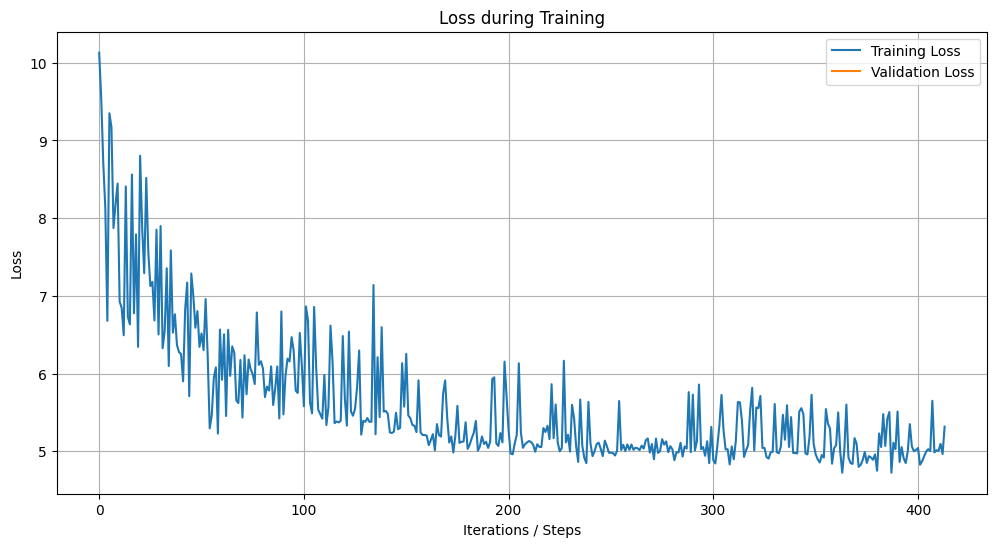

In [12]:
plt.figure(figsize=(12, 6))
plt.plot(loss_logger.train_losses, label='Training Loss')
plt.plot(loss_logger.eval_losses, label='Validation Loss')
plt.title('Loss during Training')
plt.xlabel('Iterations / Steps')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

In [13]:
# Замените 'path/to/saved/model' на путь к вашей сгенерированной модели
model = T5ForConditionalGeneration.from_pretrained('/Users/alexanderknyshov/Desktop/LLM/Data/model/checkpoint-4141').to(device)
tokenizer = T5Tokenizer.from_pretrained('/Users/alexanderknyshov/Desktop/LLM/Data/model/checkpoint-4141')

# Переводим модель в режим оценки
model.eval()

You are using a model of type mt5 to instantiate a model of type t5. This is not supported for all configurations of models and can yield errors.


T5ForConditionalGeneration(
  (shared): Embedding(20100, 512)
  (encoder): T5Stack(
    (embed_tokens): Embedding(20100, 512)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): lora.Linear(
                (base_layer): Linear(in_features=512, out_features=384, bias=False)
                (lora_dropout): ModuleDict(
                  (default): Dropout(p=0.1, inplace=False)
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=512, out_features=16, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=16, out_features=384, bias=False)
                )
                (lora_embedding_A): ParameterDict()
                (lora_embedding_B): ParameterDict()
                (lora_magnitude_vector): ModuleDict()
              )
              (k): Linear(in_featu

In [23]:
inp = "form a recommendation using news: В годовом выражении темпы роста цен сократились до 8,74%. В последний раз примерно на таком уровне инфляция была в июне. По данным Минэкономразвития, за последнюю неделю снизились цены на яблоки, картофель и овощи из борщевого набора. В продовольственном сегменте замедлился рост цен на электронику, бытовую химию и медикаменты. Кроме того, начали дешеветь услуги санаториев и гостиниц. Что самое приятное, снижаются и инфляционные ожидания россиян, причем впервые за последние четыре месяца. На прошлой неделе Эльвира Набиуллина заявила, что тренд на замедление роста цен пока не начинает формироваться, во многом из-за повышенных инфляционных ожиданий граждан и бизнеса. А раз уж они начали, наконец, снижаться, то, может, и уверенное замедление инфляции уже не за горами. А это значит, что ЦБ, возможно, больше не придется повышать ключевую ставку в этом году. В таком случае пространства для роста у нашего фондового рынка может стать гораздо больше. Кстати, тут следует отметить свежее решение ФРС США. Накануне она впервые за 4 года пошла на снижение ставки, опустив ее сразу на 50 базисных пунктов. В инвестсообществе ходят слухи, что российский ЦБ пристально следит за ФРС и в будущем может стать мягче вместе с американскими коллегами. Тезис, конечно, слегка сомнительный, но мировые центробанки точно учитывают ситуацию в США, принимая решения: все-таки это первая экономика мира. Поэтому не исключено, что снижение ставки в Штатах может стать дополнительным аргументом для Банка России, чтобы не ужесточать свою политику на следующем заседании. Подробнее: https://investfuture.ru/news/id/v-rossii-snova-zamedljaetsja-infljatsija © Investfuture.ru" #+ " ".join(["экономическая", "политическая", "нестабильность", "последнего", "времени", "привела", "падению", "продаж", "одежды", "россии", "сравнению", "аналогичным", "периодом", "прошлого", "года", "отмечают", "эксперты", "мае", "года", "оперируют", "данными", "период", "февраля", "апреля", "такое", "снижение", "спроса", "связывают", "двумя", "факторами", "вопервых", "уходом", "российского", "рынка", "крупных", "западных", "сетей", "массмаркета", "вовторых", "вынужденным", "снижением", "расходов", "многих", "россиянгазпром", "смирился", "новый", "экспортный", "маршрут", "северный", "поток", "который", "построен", "запущен", "эксплуатацию", "сможет", "набрать", "максимальную", "скорость", "поставок", "голубого", "топлива", "европу", "года", "срока", "трубам", "лучшем", "случае", "сможет", "экспортироваться", "лишь", "половина", "заявленных", "объемов", "причем", "лишь", "случае", "соответствующее", "разрешение", "даст", "германияевросоюз", "полон", "решимости", "принять", "шестой", "пакет", "санкций", "котором", "конца", "года", "предусмотрен", "полный", "отказ", "закупок", "российской", "нефти", "нефтепродуктов", "мк", "пообщался", "экспертами", "выяснить", "это", "выльется", "бюджета", "россии", "валютных", "поступленийзападные", "экономические", "издания", "продолжают", "верить", "россию", "мнению", "авторитетного", "британского", "журнала", "the", "economist", "наша", "страна", "несмотря", "связанные", "санкционным", "прессингом", "проблемы", "находит", "способы", "справиться", "предъявляемыми", "вызовами", "например", "поднятая", "рекордного", "уровня", "ключевая", "ставка", "цб", "позволила", "стабилизировать", "курс", "рубля", "вернуть", "российскую", "валюту", "уровень", "октября", "прошлого", "года", "европа", "боится", "остаться", "российских", "ресурсов", "государства", "ес", "начала", "мая", "резко", "нарастили", "запасы", "газа", "частности", "германия", "начала", "заполнять", "крупнейшее", "хранилище", "западной", "европе", "поставки", "финляндию", "выросли", "раза", "причины", "грядущий", "отопительный", "сезон", "желание", "еврокомиссии", "ввести", "эмбарго", "поставки", "россии", "наиболее", "уязвимыми", "случае", "сокращения", "импорта", "окажутся", "австрия", "финляндия", "литвапо", "данным", "газеты", "financial", "time", "западные", "банки", "отложили", "млрд", "убытки", "случае", "ухода", "россии", "причиной", "сворачивания", "прибыльного", "бизнеса", "нашей", "стране", "мировых", "финансовых", "гигантов", "являются", "введенные", "международные", "санкции", "пострадает", "банковская", "система", "россии", "отразиться", "клиентах", "мощный", "хлопок", "дверью", "стороны", "крупнейших", "банковских", "групп", "мк", "выяснил", "экспертов", "банк", "россии", "начал", "публиковать", "наиболее", "популярные", "схемы", "которые", "используют", "мошенники", "кражи", "денег", "счетов", "банковских", "карт", "россиян", "преступники", "стремятся", "оказать", "потенциальную", "жертву", "психологическое", "воздействие", "надавить", "эмоции", "отключить", "критическое", "мышление", "обошли", "вниманием", "последние", "новости", "санкциях", "блокировке", "карт", "эксперты", "рассказали", "поддаться", "манипулированию", "голод", "главная", "угроза", "нынешней", "российской", "турбулентности", "однако", "похоже", "мысль", "году", "неплохо", "посадить", "картошку", "посетила", "очень", "многих", "городских", "жителей", "результате", "подмосковных", "рынках", "образовался", "дефицит", "семенного", "картофеля", "цены", "взлетели", "продают", "картошку", "посев", "тюльпаны", "клубнями", "рублей", "штуку", "привыкшую", "санкциям", "россию", "трудно", "удивить", "какимито", "новыми", "ограничениями", "москва", "находит", "зеркальный", "ассиметричный", "ответ", "неизвестно", "несет", "большие", "финансовые", "потери", "ожиданиях", "отказа", "ес", "закупок", "российского", "газа", "нашлась", "свои", "контрмеры", "объемы", "которые", "сегодня", "поставляем", "страны", "европы", "могут", "перенаправлены", "азиатскотихоокеанский", "регион", "атр", "сбербанк", "оперативно", "отреагировал", "решение", "правительства", "рф", "увеличить", "максимальную", "сумму", "кредита", "которую", "брать", "покупку", "квартиры", "использованием", "льготной", "ставки", "мая", "покупатели", "недвижимости", "москве", "московской", "области", "санктпетербурге", "ленинградской", "области", "могут", "рассчитывать", "кредиты", "млн", "рублейстраны", "европы", "раскололись", "линии", "российского", "газа", "одни", "согласны", "схему", "оплаты", "конвертацией", "рубли", "другие", "отказались", "напрочь", "газ", "россии", "ло", "сих", "пор", "закрывал", "трети", "потребностей", "жителей", "континента", "энергоносителях", "европейцам", "приходится", "искать", "альтернативных", "поставщиков", "топлива", "россии", "нужно", "обеспечить", "аналогичный", "рынок", "сбыта", "сможет", "наша", "страна", "повернуть", "свой", "энергетический", "поток", "запада", "восток", "объяснили", "экономистыверховный", "представитель", "европейского", "союза", "иностранным", "делам", "политике", "безопасности", "жозеп", "боррель", "предложил", "странамчленам", "объединения", "обсудить", "возможность", "изъятия", "замороженных", "российских", "валютных", "резервов", "поддержки", "украины", "мид", "рф", "такую", "инициативу", "назвали", "полным", "беззаконием", "разрушением", "основы", "международных", "отношений", "эксперт", "оценил", "пойдет", "запад", "чрезвычайный", "шаг", "ответить", "россия", "большие", "магазины", "компании", "закрываются", "уходят", "россии", "фоне", "санкций", "нередко", "создавая", "колоссальный", "общественный", "резонанс", "тени", "остаётся", "малый", "бизнес", "мк", "собрал", "истории", "нескольких", "предпринимателей", "которые", "сегодня", "остались", "своими", "проблемами", "опустили", "руки", "специальная", "военная", "операция", "развязанная", "западом", "санкционная", "политика", "против", "россии", "оформили", "завершение", "политического", "хх", "века", "мировой", "арене", "снижается", "часто", "сходит", "роль", "традиционных", "мировых", "политикоэкономических", "игроковнынешний", "год", "стать", "самым", "провальным", "отрезком", "времени", "экономики", "нашей", "страны", "последние", "десятка", "лет", "данным", "агентства", "bloomberg", "недрах", "минфина", "рф", "прорабатывается", "прогноз", "соответствии", "которым", "потери", "отечественного", "ввп", "м", "составят", "наблюдалось", "годаминэкономразвития", "порадовало", "россиян", "новыми", "статистическими", "выкладками", "инфляция", "стране", "разогналась", "годовом", "выражении", "это", "вдвое", "прошлогоднего", "индекса", "роста", "потребительских", "цен", "несколько", "выше", "целевых", "показателей", "достичь", "которых", "обещало", "населению", "правительствофонды", "обязательного", "медицинского", "пенсионного", "социального", "страхования", "получат", "правительства", "трлн", "рублей", "качестве", "компенсации", "отсрочку", "уплаты", "страховых", "взносов", "предоставленную", "государством", "ряду", "отечественных", "предприятий", "снижения", "финансовой", "нагрузки", "словам", "премьерминистра", "михаила", "мишустина", "денежный", "транш", "позволит", "социальным", "фондам", "продолжить", "бесперебойную", "выдачу", "людям", "пенсий", "пособий", "также", "послужит", "залогом", "оказания", "бесплатной", "медицинской", "помощиидея", "овладевшая", "массами", "становится", "материальной", "силой", "учили", "классики", "марксизма", "точки", "зрения", "идея", "конфискации", "российских", "валютных", "резервов", "весьма", "близка", "воплощению", "стремительно", "покоряет", "евроатлантический", "политбомонд", "свидетельствуют", "частности", "недавние", "высказывания", "главы", "евродипломатии", "жозепа", "борреля", "россия", "спасти", "свои", "арестованные", "активы", "экспроприации"])
input_ids = tokenizer.encode(inp, return_tensors='pt').to(device)  

In [26]:
with torch.no_grad():  # Выключаем градиенты для оценки
    outputs = model.generate(
    input_ids,               # Входные данные
    max_length=100,           # Максимальная длина генерации
    do_sample=True,          # Включаем семплирование для большего разнообразия
    temperature=0.9,         # Увеличиваем случайность при генерации
    top_k=40,                # Ограничиваем выбор до 50 наиболее вероятных слов
    top_p=0.9,               # Вероятностное отсечение
    no_repeat_ngram_size=2,  # Предотвращаем повторение одинаковых биграмм
    length_penalty=1.0       # Регулируем длину генерации
) # Установите max_length по мере необходимости

# Декодируем сгенерированные идентификаторы в текст
generated_text = tokenizer.decode(outputs[0], skip_special_tokens=False)
generated_text

'<pad>Прогноз дня в ходе переговоров выдвигают новость накануне итальянский "ЛБ" сейчас продолжает просматривать рынок повышенной ожидания будет снижаться ниже показателей индекса российского нефти впервые за неделю с 1 марта может расти еще третье время, когда повышает цены на рынке вторник серьезно не ускорит'